https://blog.nviso.eu/2019/11/20/3-techniques-to-defend-your-machine-learning-models-against-adversarial-attacks/

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [2]:
import os
os.getcwd()

'C:\\Users\\anass\\Desktop\\TUM\\Courses\\Practical\\Github\\Practical-Course---Analysis-of-new-phenomena-in-machine-deep-learning'

In [2]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 42.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [3]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from zipfile import ZipFile

with ZipFile('data and models/saved_models_1.zip') as zipping:
    # printing all the contents of the zip file
    zipping.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zipping.extractall()
    print('Done!')


File Name                                             Modified             Size
content/saved_models/                          2023-05-30 09:34:24            0
content/saved_models/model_0.h5                2023-05-30 09:18:32      3204088
content/saved_models/model_2.h5                2023-05-30 09:18:32      3204088
content/saved_models/model_3.h5                2023-05-30 09:18:32      3203992
content/saved_models/model_1.h5                2023-05-30 09:18:32      3205744
content/saved_models/acc_array.pkl             2023-05-30 09:31:06         1749
content/saved_models/full_np.pkl               2023-05-30 09:33:52      6442480
content/saved_models/acc_aqsdrray.pkl          2023-05-30 09:33:32      6442480
content/saved_models/.ipynb_checkpoints/       2023-05-30 09:34:24            0
Extracting all the files now...
Done!


In [6]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ReLU, GlobalAveragePooling2D, Dense, Lambda, GlobalMaxPooling2D,Flatten
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescentTensorFlowV2
from tqdm import tqdm
import os
from art.utils import load_mnist




In [13]:
import pickle

with open("content/saved_models/acc_array.pkl", 'rb') as pickle_file:
    acc_array = pickle.load(pickle_file)


In [5]:
 # Set GPU device
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices("GPU")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
def circular_padding(x, padding_size):
    # Perform circular padding on the input tensor
    return tf.pad(x, [[0, 0], [padding_size, padding_size], [padding_size, padding_size], [0, 0]], mode='SYMMETRIC')

def simple_Conv(n_hidden, kernel_size=28, padding_size=-1):
    if padding_size == -1:
        padding_size = kernel_size // 2

    model = Sequential()
    model.add(Lambda(lambda x: circular_padding(x, padding_size), input_shape=(28, 28, 1)))
    model.add(Conv2D(n_hidden, kernel_size=kernel_size, padding='valid'))
    model.add(ReLU())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(10))

    return model

def simple_Conv_NL(n_hidden,kernel_size=28):
    """ no lambda """
    model = Sequential()
    model.add(Conv2D(n_hidden, kernel_size=kernel_size, padding='same', input_shape=(28, 28, 1), activation='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(10))

    return model

def simple_FC(n_hidden):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(n_hidden, activation="relu"))
    model.add(Dense(10))

    return model

def simple_Conv_max(n_hidden, kernel_size=28):
    model = Sequential()
    model.add(Conv2D(n_hidden, kernel_size=kernel_size, padding='same', input_shape=(28, 28, 1), activation='relu'))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(10))

    return model

model_names = {'simple_FC':simple_FC, 'simple_Conv':simple_Conv, 'simple_Conv_NL':simple_Conv_NL, 'simple_Conv_max':simple_Conv_max}

In [14]:
simple_FC = tf.keras.models.load_model('content/saved_models/model_0.h5')
simple_Conv = tf.keras.models.load_model('content/saved_models/model_1.h5')
simple_Conv_NL = tf.keras.models.load_model('content/saved_models/model_2.h5')
simple_Conv_max   = tf.keras.models.load_model('content/saved_models/model_3.h5')
models = [simple_FC, simple_Conv, simple_Conv_NL, simple_Conv_max]
models = [[models[i]] + acc_array[i].tolist() for i in range(len(models))]

(array([ 85., 126., 116., 107., 110.,  87.,  87.,  99.,  89.,  94.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

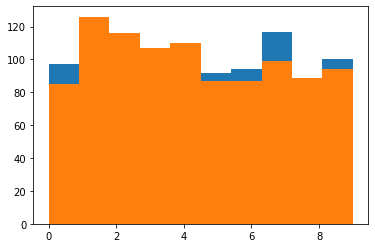

In [15]:

# Load MNIST dataset
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

x_train = x_train[:1000] #3000
y_train = y_train[:1000]
x_test = x_test[:1000] #500
y_test = y_test[:1000]
# change to 1000 - 1000
import matplotlib.pyplot as plt
plt.hist(np.argmax(y_train, axis=1))
plt.hist(np.argmax(y_test, axis=1))


In [8]:

  
def create_art_classifier(model_creator, x_train=x_train, y_train=y_train, batch_size=64, nb_epochs=20, **kwargs):
    #n_hidden=1000,kernel_size=28,padding_size=-1
    # Create the CNN model and optimizer
    model_name = list(model_names.keys())[list(model_names.values()).index(model_creator)]
    train_acc = []
    test_acc = []
    model = None
    optimizer = None
    loss_object = None
    classifier = None
    model = model_creator(**kwargs)
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.1, momentum=0.9, decay=5e-4)
    loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer,
                  loss=loss_object,
                  metrics=['accuracy'])
    
    @tf.function
    def train_step(model, images, labels):
        with tf.GradientTape() as tape:
            predictions = model(images, training=True)
            loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Create the ART classifier
    classifier = TensorFlowV2Classifier(
        model=model,
        loss_object=loss_object,
        train_step=train_step,
        nb_classes=10,
        input_shape=(28, 28, 1),
        clip_values=(0, 1),
    )

    # Fit the classifier to the training data
    classifier.fit(x_train, y_train, batch_size=batch_size, nb_epochs=nb_epochs) #, verbose=2)
    # Perform predictions and evaluate accuracy on examples
    predictions = classifier.predict(x_test)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
    test_acc.append(accuracy)
    print("Model : {} - Accuracy on test examples: {}%".format( model_name,accuracy * 100))
    predictions = classifier.predict(x_train)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_train, axis=1)) / len(y_train)
    train_acc.append(accuracy)
    print("Model : {} - Accuracy on train examples: {}%".format( model_name, accuracy * 100 ))

    return [classifier, test_acc, train_acc] 



In [9]:
padding_sizes = [0, 2, 4, 6, 8, 10, 12, 14]
#padding_size=-1
padding_size = padding_sizes[3]
n_hidden = 500 #1000
kernel_size=28

In [10]:
models = [
    create_art_classifier(model_creator=simple_FC, x_train=x_train, y_train=y_train, n_hidden=n_hidden),
    create_art_classifier(model_creator=simple_Conv, x_train=x_train, y_train=y_train, n_hidden=n_hidden, kernel_size=kernel_size, padding_size=padding_size),
    create_art_classifier(model_creator=simple_Conv_NL, x_train=x_train, y_train=y_train, n_hidden=n_hidden, kernel_size=kernel_size),
    create_art_classifier(model_creator=simple_Conv_max, x_train=x_train, y_train=y_train, n_hidden=n_hidden, kernel_size=kernel_size)
]


Model : simple_FC - Accuracy on test examples: 87.1%
Model : simple_FC - Accuracy on train examples: 100.0%
Model : simple_Conv - Accuracy on test examples: 72.6%
Model : simple_Conv - Accuracy on train examples: 81.89999999999999%
Model : simple_Conv_NL - Accuracy on test examples: 63.6%
Model : simple_Conv_NL - Accuracy on train examples: 74.5%
Model : simple_Conv_max - Accuracy on test examples: 95.19999999999999%
Model : simple_Conv_max - Accuracy on train examples: 100.0%


with padding size 5

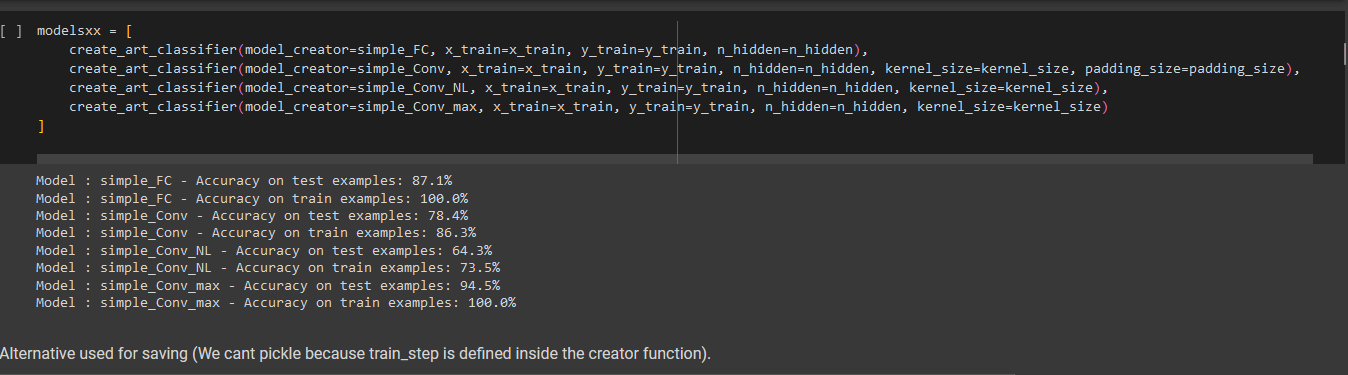

Alternative used for saving (We cant pickle because train_step is defined inside the creator function).

---

* cloudpickle
* dill
* pickle
* model.save
* joblib





In [ ]:
import numpy as np
import tensorflow as tf
from art.estimators.classification import TensorFlowV2Classifier

def train_step(model, optimizer, loss_object, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def create_art_classifier(model_creator, x_train, y_train, batch_size=64, nb_epochs=10, **kwargs): # nb_epochs=200
    # Create the CNN model and optimizer
    model = model_creator(**kwargs)
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.1, momentum=0.9, decay=5e-4)
    loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])


    # Create the ART classifier
    classifier = TensorFlowV2Classifier(
        model=model,
        loss_object=loss_object,
        train_step=train_step,
        nb_classes=10,
        input_shape=(28, 28, 1),
        clip_values=(0, 1),
    )
    # Custom training loop
    train_acc = []
    test_acc = []
    for epoch in range(nb_epochs):
        print("Epoch {}/{}".format(epoch + 1, nb_epochs))
        epoch_loss = []
        for batch in range(0, len(x_train), batch_size):
            batch_images = x_train[batch:batch + batch_size]
            batch_labels = y_train[batch:batch + batch_size]
            loss = train_step(model, optimizer, loss_object, batch_images, batch_labels)
            epoch_loss.append(loss)
        avg_loss = np.mean(epoch_loss)
        print("Average loss: {:.4f}".format(avg_loss))

        # Perform predictions and evaluate accuracy on examples
        predictions = classifier.predict(x_test)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        test_acc.append(accuracy)
        print("Accuracy on test examples: {:.2%}".format(accuracy))

        predictions = classifier.predict(x_train)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_train, axis=1)) / len(y_train)
        train_acc.append(accuracy)
        print("Accuracy on train examples: {:.2%}".format(accuracy))

    return [classifier, test_acc, train_acc]

# Usage
models = [
    create_art_classifier(model_creator=simple_FC, x_train=x_train, y_train=y_train, n_hidden=n_hidden),
    create_art_classifier(model_creator=simple_Conv, x_train=x_train, y_train=y_train, n_hidden=n_hidden, kernel_size=kernel_size, padding_size=padding_size),
    create_art_classifier(model_creator=simple_Conv_NL, x_train=x_train, y_train=y_train, n_hidden=n_hidden, kernel_size=kernel_size),
    create_art_classifier(model_creator=simple_Conv_max, x_train=x_train, y_train=y_train, n_hidden=n_hidden, kernel_size=kernel_size)
]



In [ ]:
#simple_Conv_max(n_hidden, kernel_size=28)
#simple_FC(n_hidden)
#simple_Conv_NL(n_hidden,kernel_size=28)
#simple_Conv(n_hidden, kernel_size=28, padding_size=-1)
padding_sizes = [0, 2, 4, 6, 8, 10, 12, 14]
#padding_size=-1
padding_size = padding_sizes[5]
n_hidden = 500 #1000
kernel_size=28

models = [
    create_art_classifier(model_creator=simple_FC,n_hidden = n_hidden),
    create_art_classifier(model_creator=simple_Conv,n_hidden = n_hidden,kernel_size = kernel_size,padding_size=padding_size),
    create_art_classifier(model_creator=simple_Conv_NL,n_hidden = n_hidden,kernel_size = kernel_size),
    create_art_classifier(model_creator=simple_Conv_max,n_hidden = n_hidden, kernel_size = kernel_size)
]


In [132]:
!mkdir -p saved_models


In [135]:
!pip install cloudpickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [142]:
for i, model in enumerate(models):
    model_name = f'saved_models/model_{i}.h5'
    model[0].model.save(model_name)


In [146]:
# Recreate the exact same model, including its weights and the optimizer
#new_model = tf.keras.models.load_model('my_model.h5')


In [148]:
# Covert list2 to numpy array
array_models = np.array(models)

# Extract the specific columns from array2 according to list1
acc_array = array_models[:, [1,2]]

#  Convert the new numpy array to list of lists
newList = acc_array.tolist()

<ipython-input-148-b462029c1d19>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array_models = np.array(models)


In [149]:
import pickle

# Save the models list to a file
with open('saved_models/acc_array.pkl', 'wb') as file:
    pickle.dump(acc_array, file)

In [154]:
# Save the models list to a file
with open('saved_models/full_np.pkl', 'wb') as file:
    pickle.dump(array_models, file)

In [156]:
## Save the entire model as a SavedModel.
#!mkdir -p saved_models
#model.save('saved_models/my_model')
!zip -r /content/saved_models.zip /content/saved_models

updating: content/saved_models/ (stored 0%)
updating: content/saved_models/model_0.h5 (deflated 18%)
updating: content/saved_models/model_2.h5 (deflated 7%)
updating: content/saved_models/model_3.h5 (deflated 6%)
updating: content/saved_models/model_1.h5 (deflated 7%)
updating: content/saved_models/acc_array.pkl (deflated 60%)
updating: content/saved_models/full_np.pkl (deflated 8%)
  adding: content/saved_models/.ipynb_checkpoints/ (stored 0%)


In [157]:
from google.colab import files
files.download("/content/saved_models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# Enable GPU acceleration for ART attacks
from art.config import ART_NUMPY_DTYPE
os.environ["ART_NUMPY_DTYPE"] = str(ART_NUMPY_DTYPE)

# Define the attack parameters
attack_params = [[np.inf, [0.05,  0.15, 0.25]],[2, [0.5, 1, 1.5,  2.5]]]



In [ ]:
# Iterate over the attack parameters and generate adversarial examples
for norm, epsilons in attack_params:
    for epsilon in epsilons:
        if norm == 2:
            attack = FastGradientMethod(estimator=classifier, eps=epsilon, norm=norm)
        else:
            attack = ProjectedGradientDescentTensorFlowV2(estimator=classifier, eps=epsilon, norm=norm)

        attack_name = attack.__class__.__name__
        model_name = "simple_Conv_28_10_1000"

        adv_correct = 0
        adv_loss = 0
        total = 0
        x_train_attack = []
        y_train_attack = []
        x_test_attack = []
        y_test_attack = []

        x_train_attack = attack.generate(x=x_train)
        y_train_attack = np.copy(y_train)

        x_test_attack = attack.generate(x=x_test)
        y_test_attack = np.copy(y_test)

        x_train_attack = np.array(x_train_attack)
        y_train_attack = np.array(y_train_attack)
        x_test_attack = np.array(x_test_attack)
        y_test_attack = np.array(y_test_attack)

        save_dir = "adversarial_data"
        os.makedirs(save_dir, exist_ok=True)
        np.savez(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}_train.npz"),
                 x_train_attack=x_train_attack, y_train_attack=y_train_attack)
        np.savez(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}_test.npz"),
                 x_test_attack=x_test_attack, y_test_attack=y_test_attack)

        print(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}"))

        for x, y in tqdm(zip(x_test_attack, y_test_attack), total=len(y_test_attack),
                         desc="Evaluating Adversarial Examples"):
            predictions_adv = np.argmax(classifier.predict(np.expand_dims(x, axis=0)), axis=1)
            adv_correct += (predictions_adv == y).sum()
            total += 1

        _, adv_loss = classifier.model.evaluate(x_test_attack, y_test_attack, verbose=0)
        accuracy = adv_correct / total
        print("Accuracy on adversarial test examples (L_{:.0f}, eps={:.2f}): {:.2f}%. Loss: {:.2f}".format(
            norm, epsilon, accuracy * 100, adv_loss))

In [ ]:
for model, model_name in zip(models, model_names):
    classifier = model[0]
    # Iterate over the attack parameters and generate adversarial examples
    for norm, epsilons in attack_params:
        for epsilon in epsilons:
            if norm == 2:
                attack = FastGradientMethod(estimator=classifier, eps=epsilon, norm=norm)
            else:
                attack = ProjectedGradientDescentTensorFlowV2(estimator=classifier, eps=epsilon, norm=norm)

            attack_name = attack.__class__.__name__
            #model_name = "simple_Conv_28_10_1000"

            adv_correct = 0
            adv_loss = 0
            total = 0
            x_train_attack = []
            y_train_attack = []
            x_test_attack = []
            y_test_attack = []

            x_train_attack = attack.generate(x=x_train)
            y_train_attack = np.copy(y_train)

            x_test_attack = attack.generate(x=x_test)
            y_test_attack = np.copy(y_test)

            x_train_attack = np.array(x_train_attack)
            y_train_attack = np.array(y_train_attack)
            x_test_attack = np.array(x_test_attack)
            y_test_attack = np.array(y_test_attack)

            save_dir = "adversarial_data"
            os.makedirs(save_dir, exist_ok=True)
            np.savez(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}_train.npz"),
                    x_train_attack=x_train_attack, y_train_attack=y_train_attack)
            np.savez(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}_test.npz"),
                    x_test_attack=x_test_attack, y_test_attack=y_test_attack)

            print(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}"))

            for x, y in tqdm(zip(x_test_attack, y_test_attack), total=len(y_test_attack),
                            desc="Evaluating Adversarial Examples"):
                predictions_adv = np.argmax(classifier.predict(np.expand_dims(x, axis=0)), axis=1)
                adv_correct += (predictions_adv == y).sum()
                total += 1

            _, adv_loss = classifier.model.evaluate(x_test_attack, y_test_attack, verbose=0)
            accuracy = adv_correct / total
            print("Accuracy on adversarial test examples (L_{:.0f}, eps={:.2f}): {:.2f}%. Loss: {:.2f}".format(
                norm, epsilon, accuracy * 100, adv_loss))

adversarial_data/simple_FC_ProjectedGradientDescentTensorFlowV2_0.05

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 289.34it/s]

Accuracy on adversarial test examples (L_inf, eps=0.05): 83.70%. Loss: 0.62

adversarial_data/simple_FC_ProjectedGradientDescentTensorFlowV2_0.15

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 278.87it/s]

Accuracy on adversarial test examples (L_inf, eps=0.15): 33.20%. Loss: 0.09

adversarial_data/simple_FC_ProjectedGradientDescentTensorFlowV2_0.25

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 287.55it/s]

Accuracy on adversarial test examples (L_inf, eps=0.25): 26.00%. Loss: 0.08
adversarial_data/simple_FC_FastGradientMethod_0.5

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 285.92it/s]

Accuracy on adversarial test examples (L_2, eps=0.50): 88.80%. Loss: 0.80
adversarial_data/simple_FC_FastGradientMethod_1

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:04<00:00, 249.32it/s]

Accuracy on adversarial test examples (L_2, eps=1.00): 81.10%. Loss: 0.61
adversarial_data/simple_FC_FastGradientMethod_1.5

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 288.73it/s]

Accuracy on adversarial test examples (L_2, eps=1.50): 67.60%. Loss: 0.38
adversarial_data/simple_FC_FastGradientMethod_2.5

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 279.75it/s]

Accuracy on adversarial test examples (L_2, eps=2.50): 34.40%. Loss: 0.14

adversarial_data/simple_Conv_ProjectedGradientDescentTensorFlowV2_0.05

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:05<00:00, 198.54it/s]

Accuracy on adversarial test examples (L_inf, eps=0.05): 52.90%. Loss: 0.36

PGD - Batches:
5/? [00:30<00:00, 3.78s/it]

adversarial_data/simple_Conv_ProjectedGradientDescentTensorFlowV2_0.15

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:04<00:00, 235.64it/s]

Accuracy on adversarial test examples (L_inf, eps=0.15): 22.50%. Loss: 0.06

adversarial_data/simple_Conv_ProjectedGradientDescentTensorFlowV2_0.25

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:04<00:00, 234.88it/s]

Accuracy on adversarial test examples (L_inf, eps=0.25): 8.10%. Loss: 0.05
adversarial_data/simple_Conv_FastGradientMethod_0.5

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:04<00:00, 207.37it/s]

Accuracy on adversarial test examples (L_2, eps=0.50): 65.10%. Loss: 0.63
adversarial_data/simple_Conv_FastGradientMethod_1

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:04<00:00, 237.07it/s]

Accuracy on adversarial test examples (L_2, eps=1.00): 52.80%. Loss: 0.41
adversarial_data/simple_Conv_FastGradientMethod_1.5

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:04<00:00, 207.95it/s]

Accuracy on adversarial test examples (L_2, eps=1.50): 43.60%. Loss: 0.28
adversarial_data/simple_Conv_FastGradientMethod_2.5

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:04<00:00, 233.65it/s]

Accuracy on adversarial test examples (L_2, eps=2.50): 27.30%. Loss: 0.16

adversarial_data/simple_Conv_NL_ProjectedGradientDescentTensorFlowV2_0.05

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 287.08it/s]

Accuracy on adversarial test examples (L_inf, eps=0.05): 360.40%. Loss: 0.30

adversarial_data/simple_Conv_NL_ProjectedGradientDescentTensorFlowV2_0.15

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 290.24it/s]

Accuracy on adversarial test examples (L_inf, eps=0.15): 781.30%. Loss: 0.08

adversarial_data/simple_Conv_NL_ProjectedGradientDescentTensorFlowV2_0.25

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 288.03it/s]

Accuracy on adversarial test examples (L_inf, eps=0.25): 751.60%. Loss: 0.05
adversarial_data/simple_Conv_NL_FastGradientMethod_0.5

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 252.74it/s]

Accuracy on adversarial test examples (L_2, eps=0.50): 158.10%. Loss: 0.59
adversarial_data/simple_Conv_NL_FastGradientMethod_1

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 285.58it/s]

Accuracy on adversarial test examples (L_2, eps=1.00): 206.40%. Loss: 0.41
adversarial_data/simple_Conv_NL_FastGradientMethod_1.5

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:04<00:00, 249.70it/s]

Accuracy on adversarial test examples (L_2, eps=1.50): 234.30%. Loss: 0.31
adversarial_data/simple_Conv_NL_FastGradientMethod_2.5

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 287.93it/s]

Accuracy on adversarial test examples (L_2, eps=2.50): 303.70%. Loss: 0.19

adversarial_data/simple_Conv_max_ProjectedGradientDescentTensorFlowV2_0.05

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 261.12it/s]

Accuracy on adversarial test examples (L_inf, eps=0.05): 88.50%. Loss: 0.85

adversarial_data/simple_Conv_max_ProjectedGradientDescentTensorFlowV2_0.15

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 287.54it/s]

Accuracy on adversarial test examples (L_inf, eps=0.15): 64.90%. Loss: 0.11

adversarial_data/simple_Conv_max_ProjectedGradientDescentTensorFlowV2_0.25

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 285.30it/s]

Accuracy on adversarial test examples (L_inf, eps=0.25): 33.70%. Loss: 0.03
adversarial_data/simple_Conv_max_FastGradientMethod_0.5

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 285.63it/s]

Accuracy on adversarial test examples (L_2, eps=0.50): 88.30%. Loss: 0.92
adversarial_data/simple_Conv_max_FastGradientMethod_1

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 281.78it/s]

Accuracy on adversarial test examples (L_2, eps=1.00): 90.70%. Loss: 0.81
adversarial_data/simple_Conv_max_FastGradientMethod_1.5

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 287.04it/s]

Accuracy on adversarial test examples (L_2, eps=1.50): 88.10%. Loss: 0.67
adversarial_data/simple_Conv_max_FastGradientMethod_2.5

Evaluating Adversarial Examples: 100%|██████████| 1000/1000 [00:03<00:00, 289.99it/s]

Accuracy on adversarial test examples (L_2, eps=2.50): 77.30%. Loss: 0.30


In [17]:
!zip -r /content/adversarial_data.zip /content/adversarial_data

  adding: content/adversarial_data/ (stored 0%)
  adding: content/adversarial_data/simple_Conv_NL_FastGradientMethod_1_test.npz (deflated 41%)
  adding: content/adversarial_data/simple_Conv_max_ProjectedGradientDescentTensorFlowV2_0.25_train.npz (deflated 86%)
  adding: content/adversarial_data/simple_Conv_NL_FastGradientMethod_1.5_test.npz (deflated 41%)
  adding: content/adversarial_data/simple_Conv_FastGradientMethod_1_train.npz (deflated 42%)
  adding: content/adversarial_data/simple_Conv_NL_FastGradientMethod_1_train.npz (deflated 39%)
  adding: content/adversarial_data/simple_FC_ProjectedGradientDescentTensorFlowV2_0.05_test.npz (deflated 86%)
  adding: content/adversarial_data/simple_Conv_ProjectedGradientDescentTensorFlowV2_0.25_test.npz (deflated 90%)
  adding: content/adversarial_data/simple_Conv_FastGradientMethod_1_test.npz (deflated 43%)
  adding: content/adversarial_data/simple_Conv_FastGradientMethod_1.5_test.npz (deflated 43%)
  adding: content/adversarial_data/simple_C

In [20]:
from google.colab import files
files.download("/content/adversarial_data.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
 model, model_name in zip(models, model_names):
    classifier = model[0]


physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=5e-4)
 #uses tf.keras.optimizers.SGD instead of tf.keras.optimizers.legacy.SGD, as the legacy version does not support GPU acceleration in TensorFlow 2.x. 

In [35]:
import matplotlib.pyplot as plt

# Step 1: Load the attack data
attack_data = {}
attack_params = [[np.inf, [0.05, 0.15, 0.25]], [2, [0.5, 1, 1.5, 2.5]]]  # Example attack parameters

for model_name, model in zip(model_names,models):
    for norm, epsilons in attack_params:
        for epsilon in epsilons:
            for data_type in ["train", "test"]:
                if norm == np.inf:
                    attack_name = "ProjectedGradientDescentTensorFlowV2"
                else:
                    attack_name = "FastGradientMethod"
                file_name = f"/content/adversarial_data/{model_name}_{attack_name}_{epsilon}_{data_type}.npz"  # Modify the file name pattern as per your data
                attack_data[(model_name, norm, epsilon,data_type)] = (model,np.load(file_name))


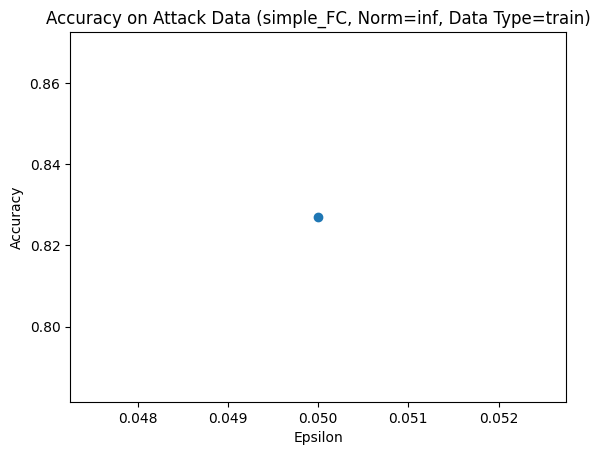

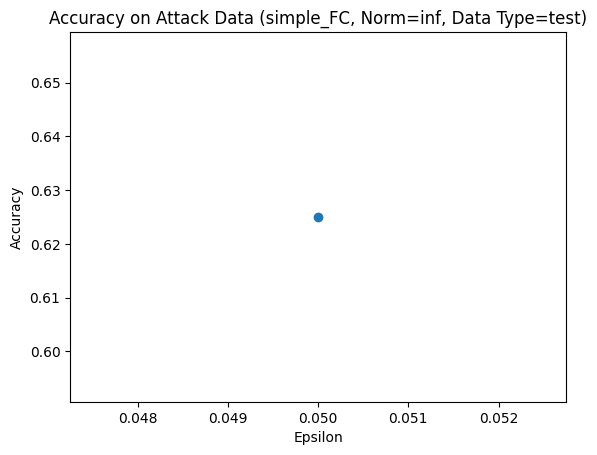

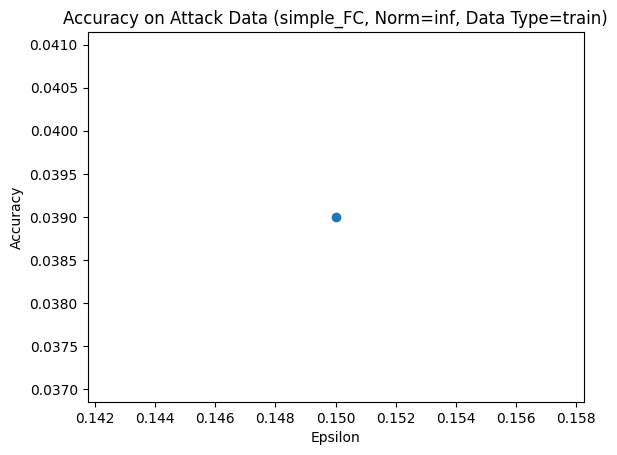

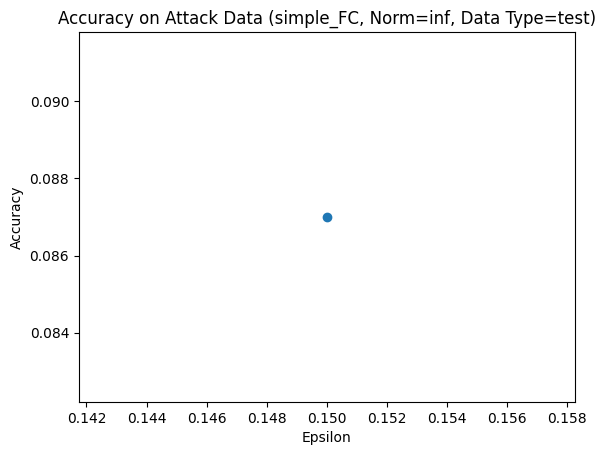

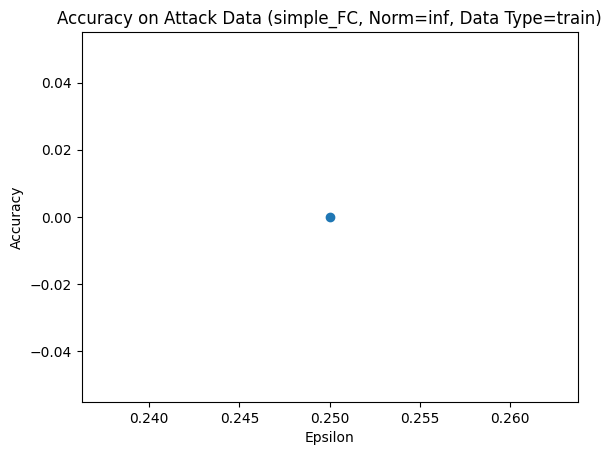

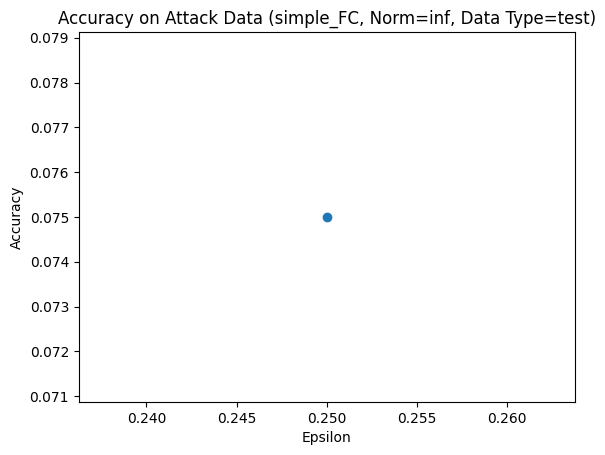

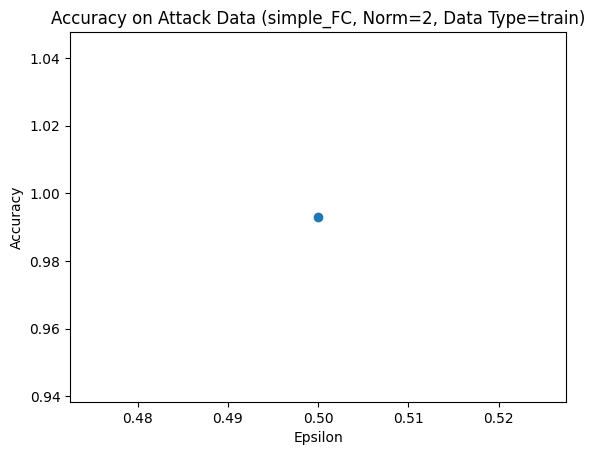

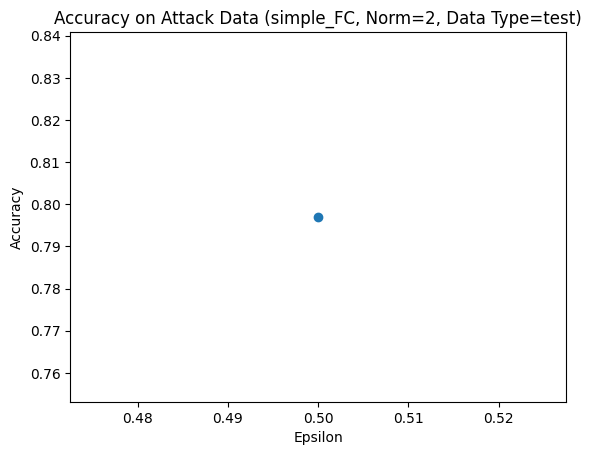

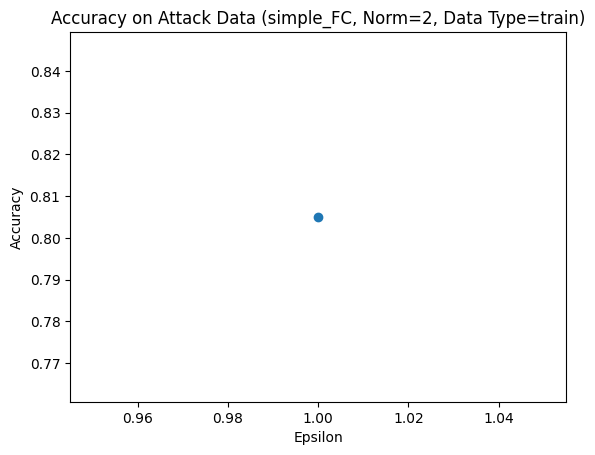

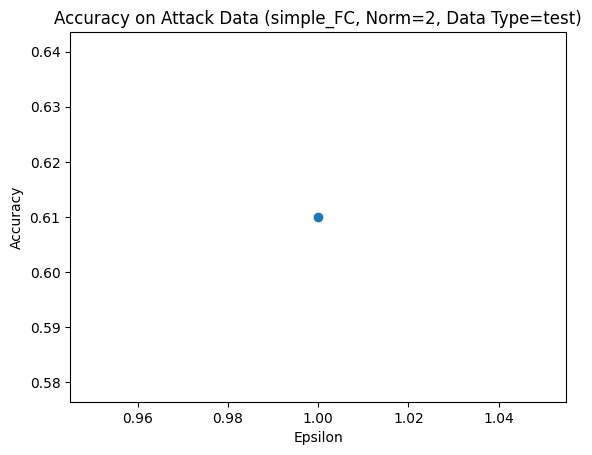

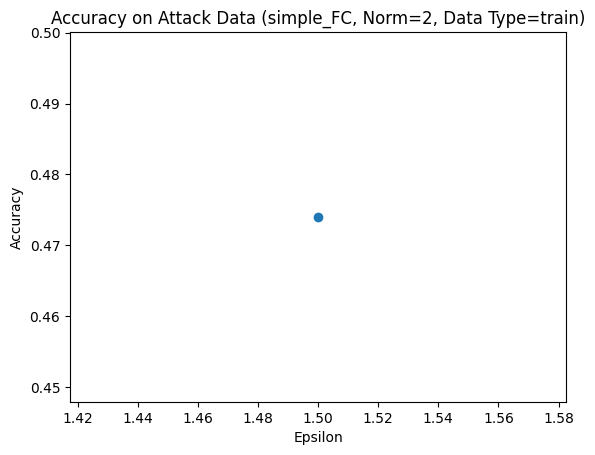

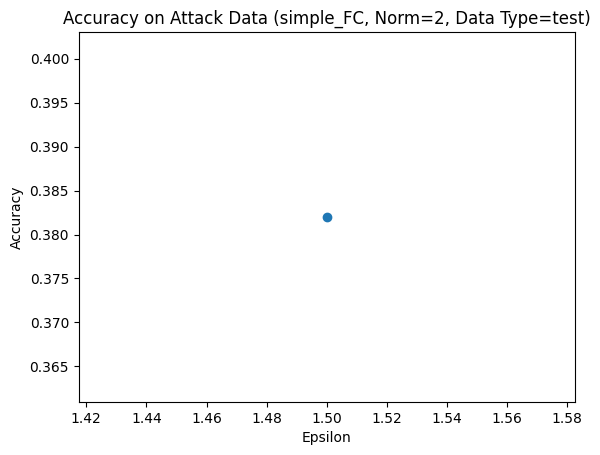

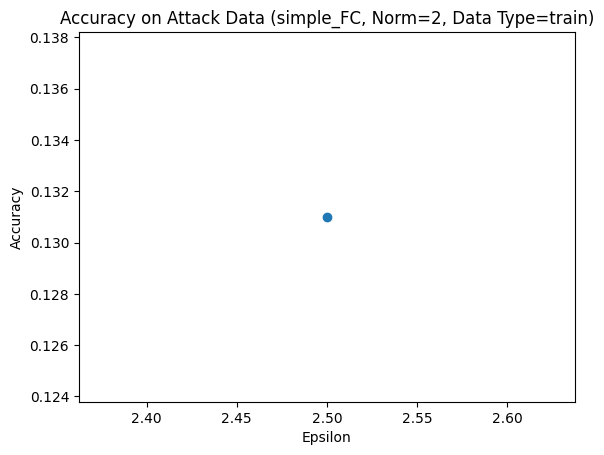

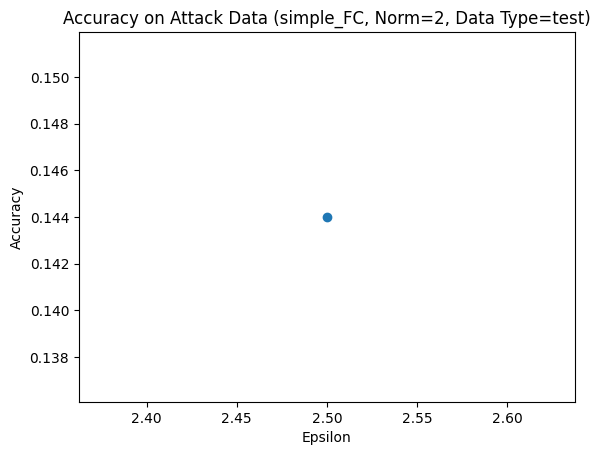

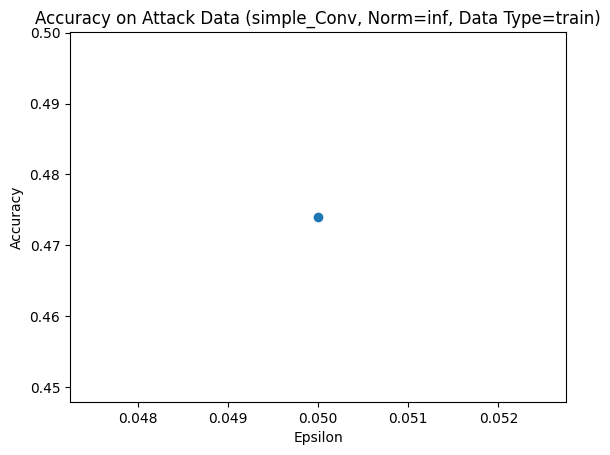

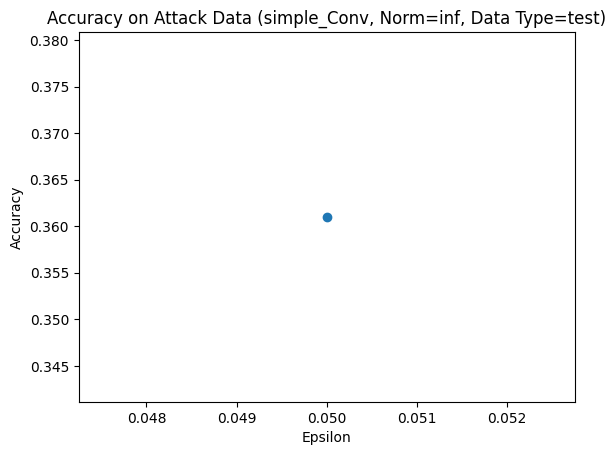

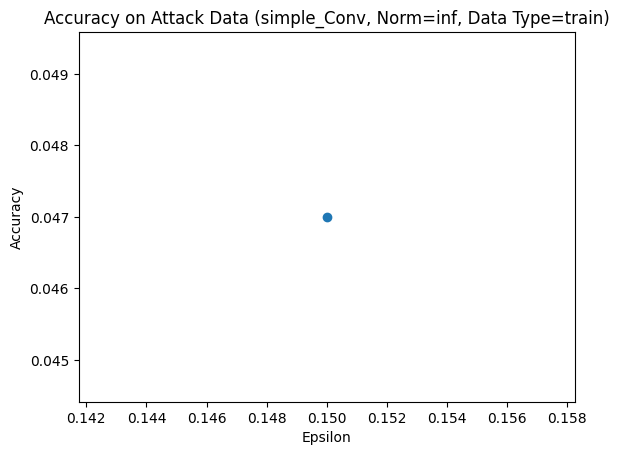

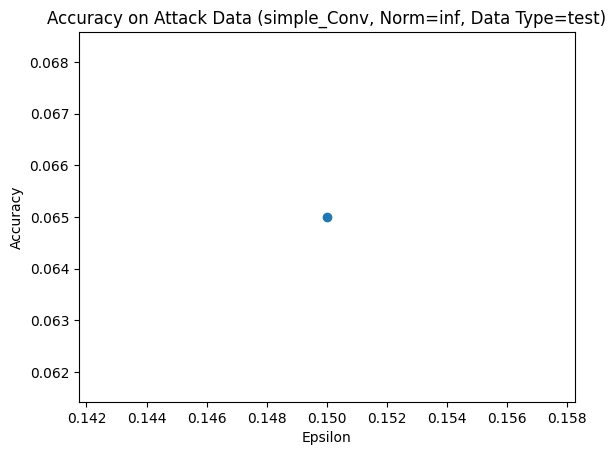

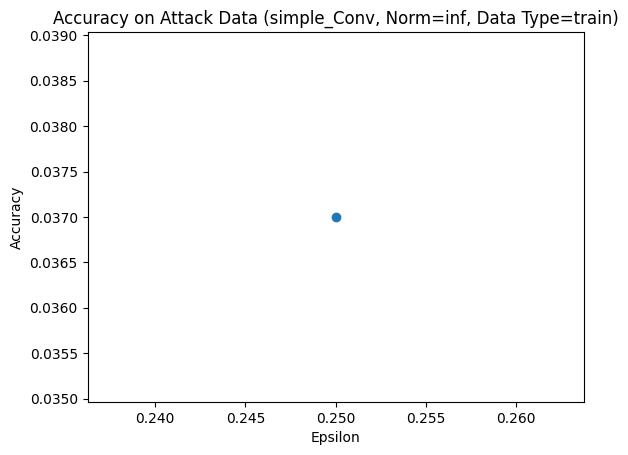

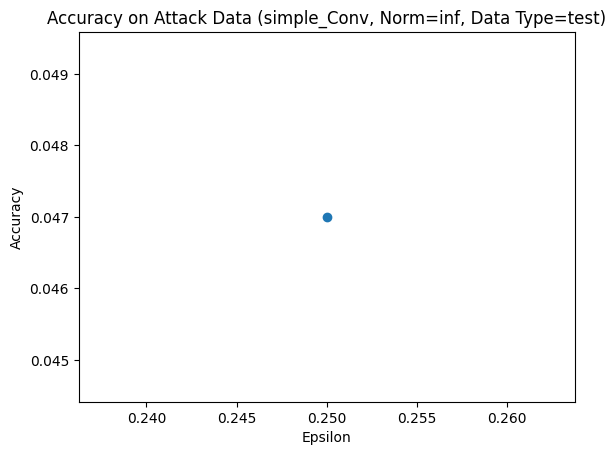

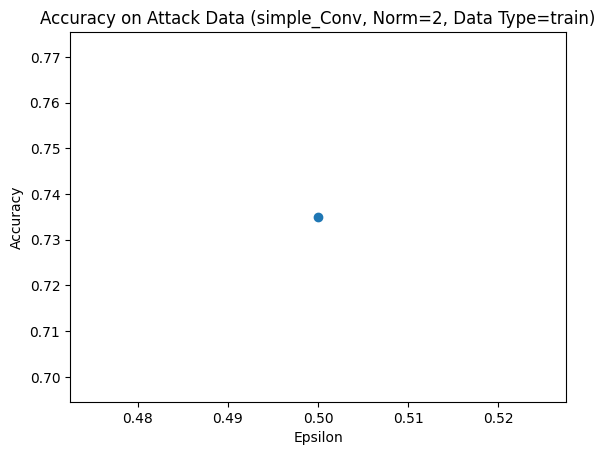

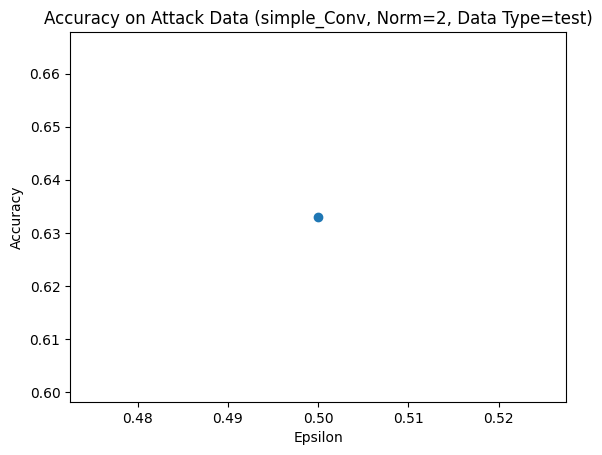

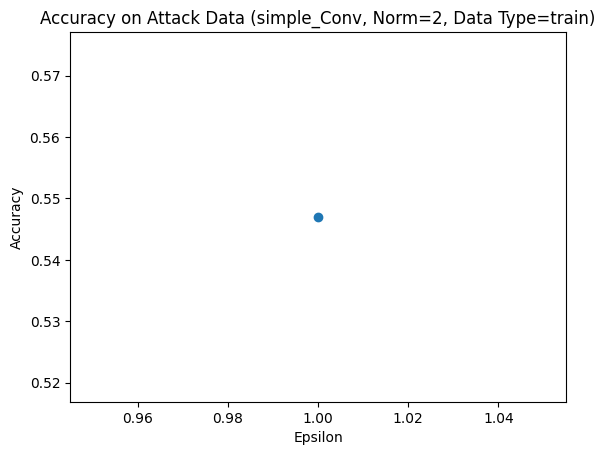

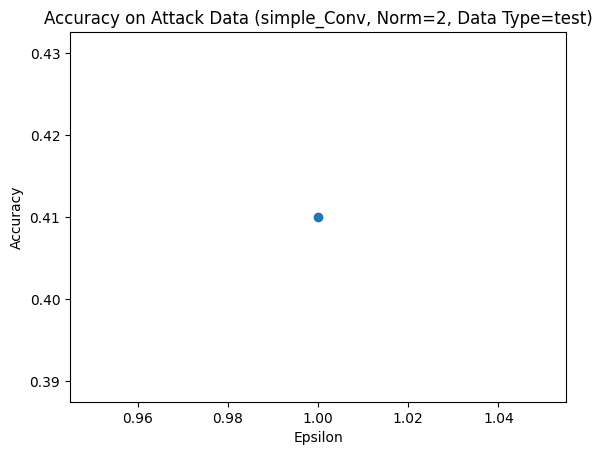

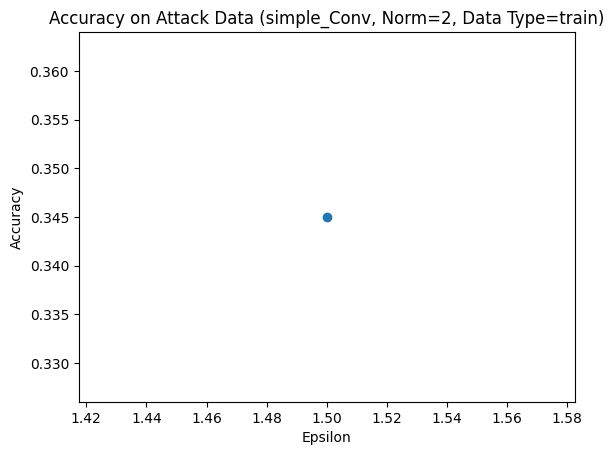

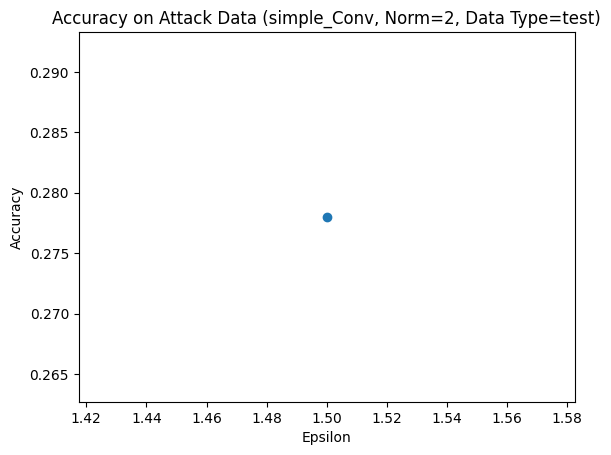

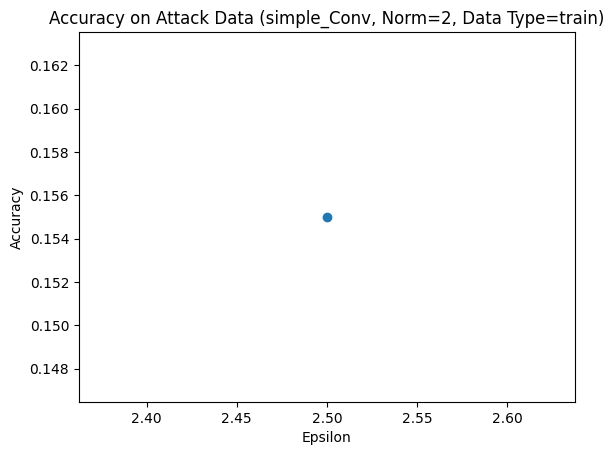

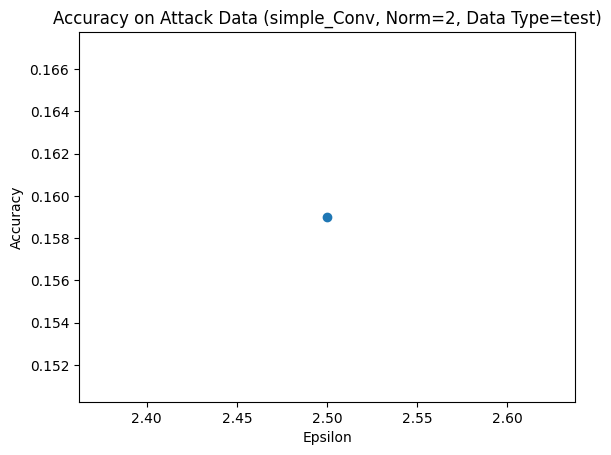

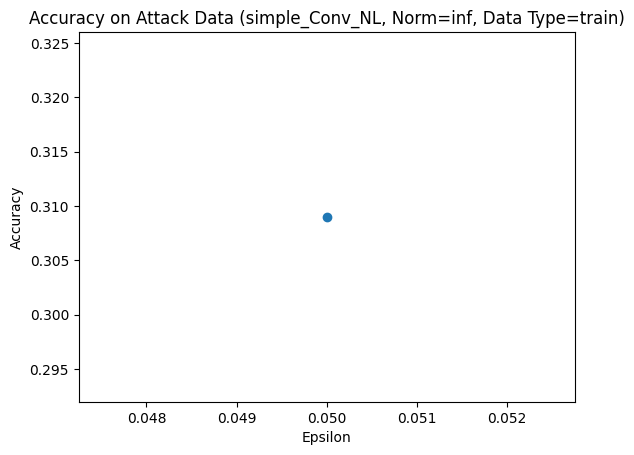

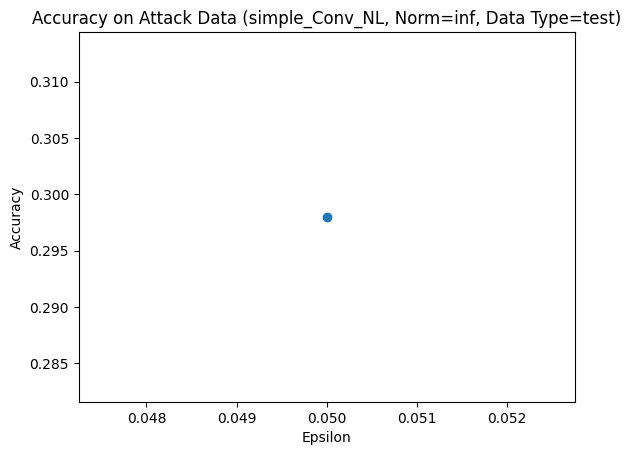

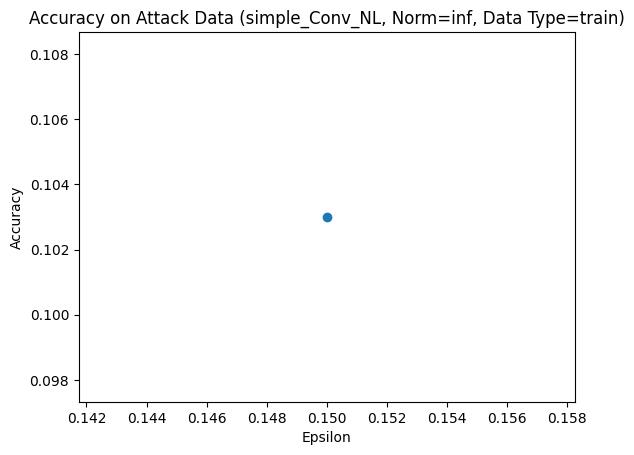

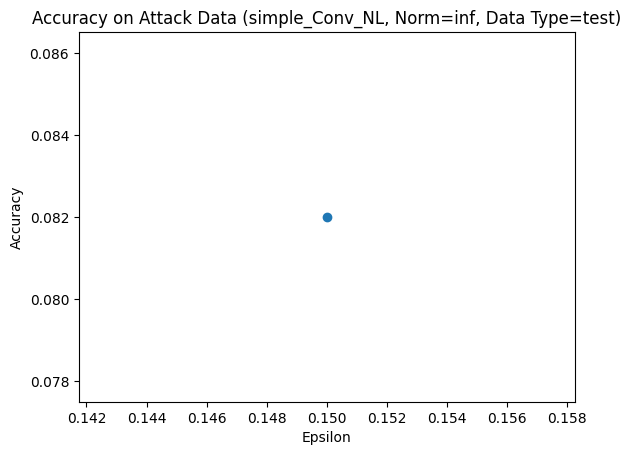

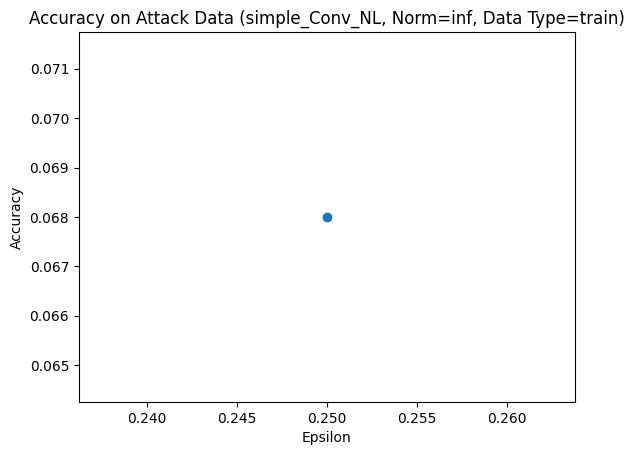

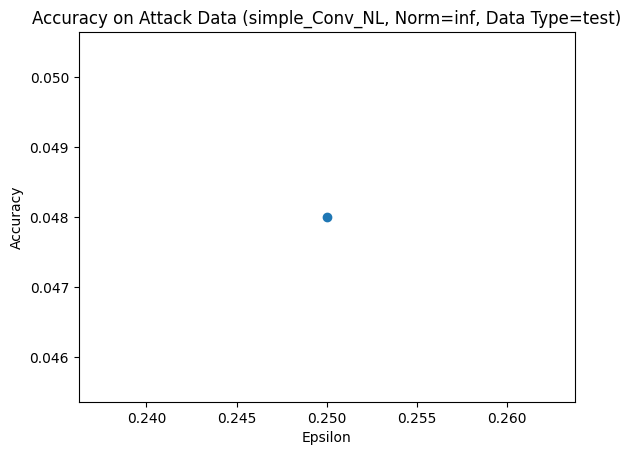

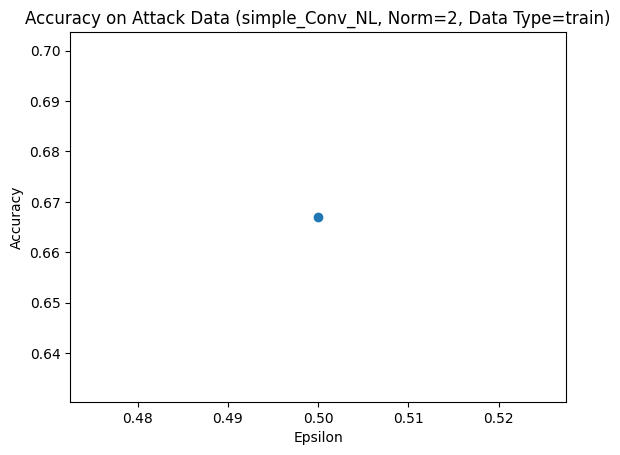

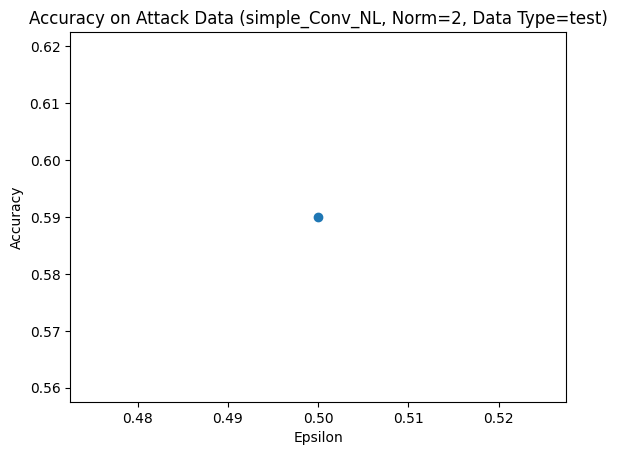

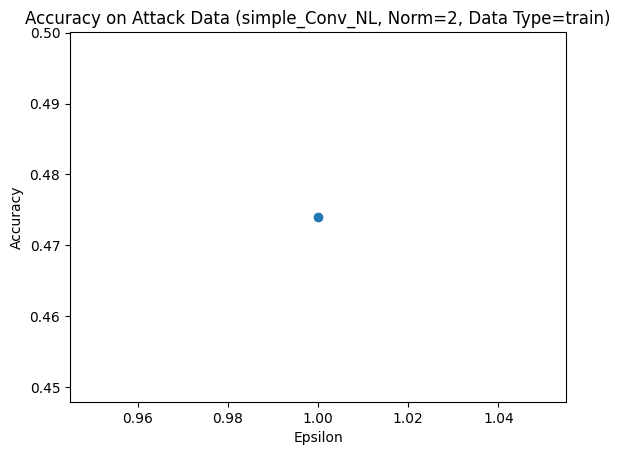

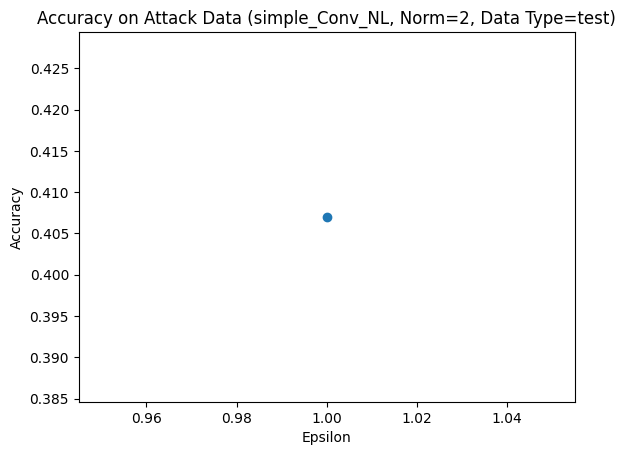

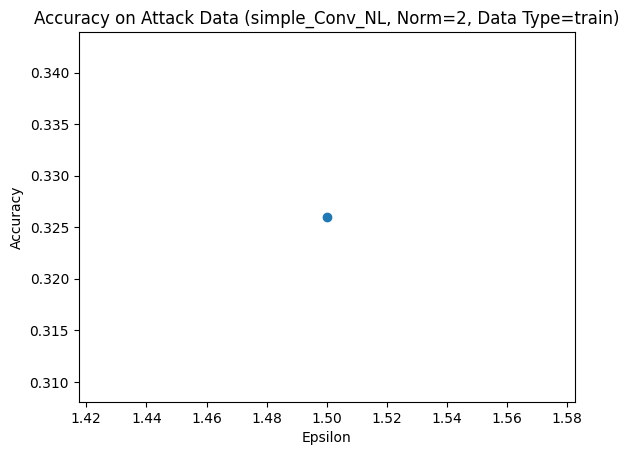

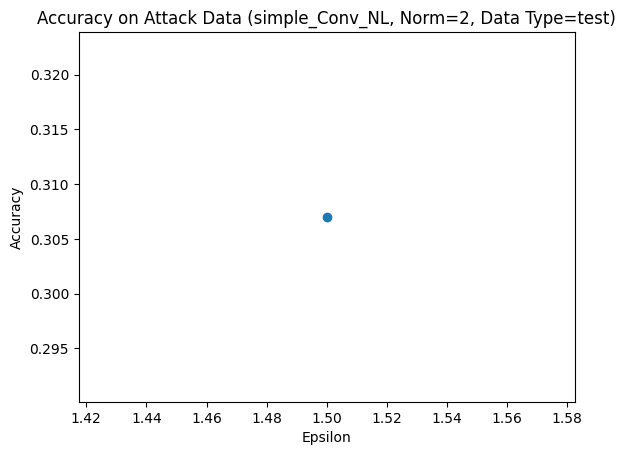

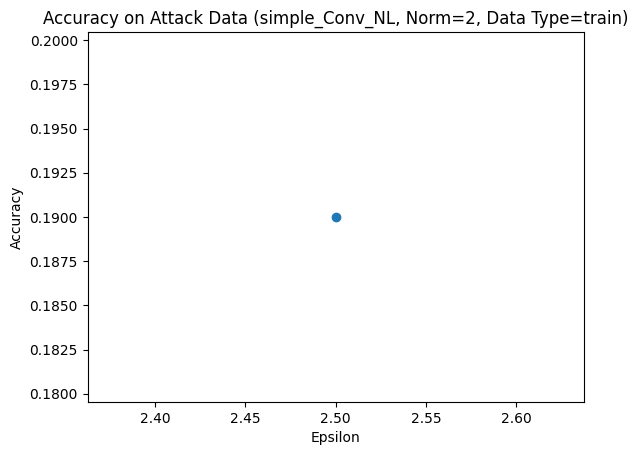

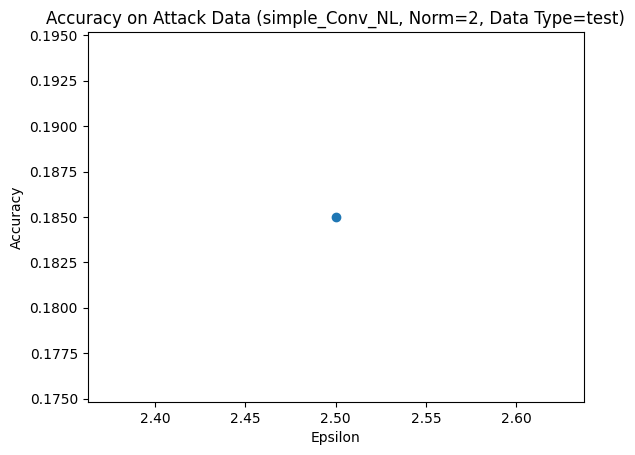

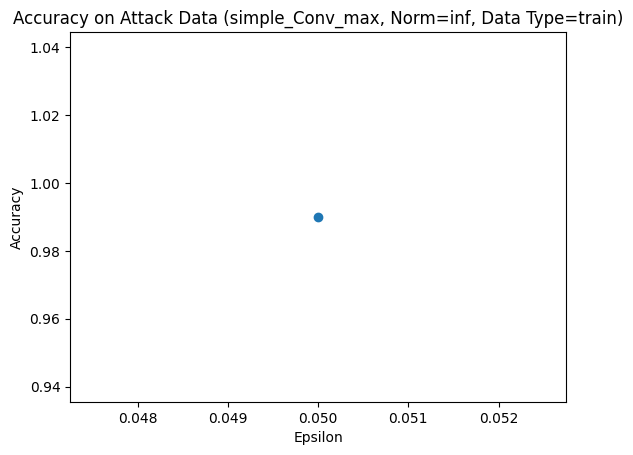

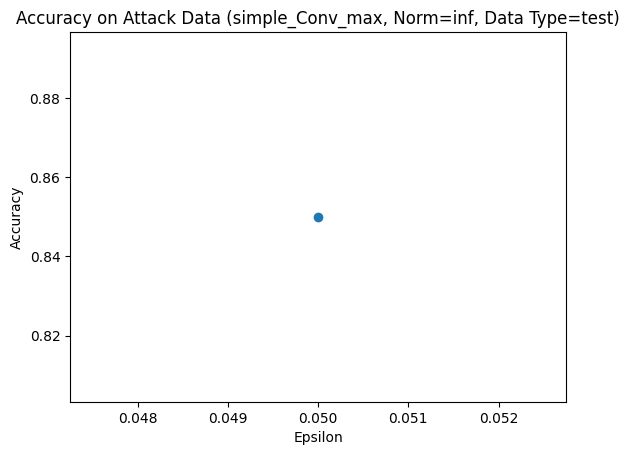

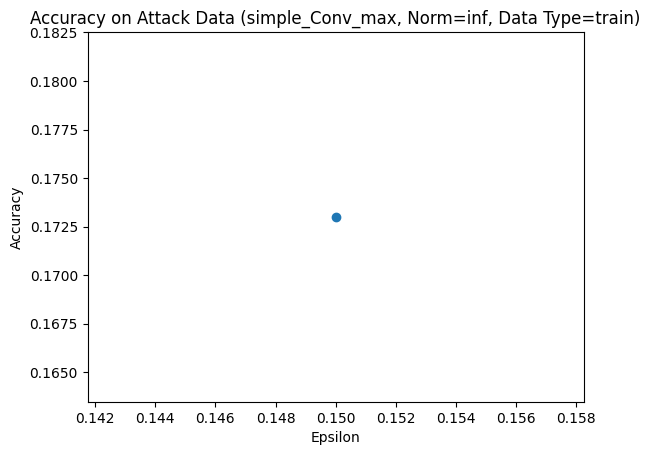

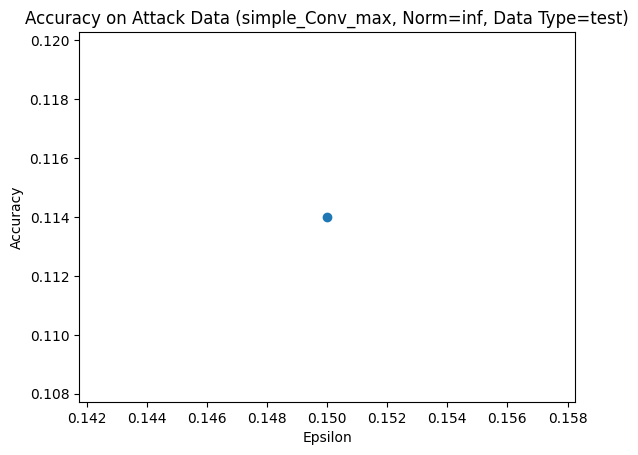

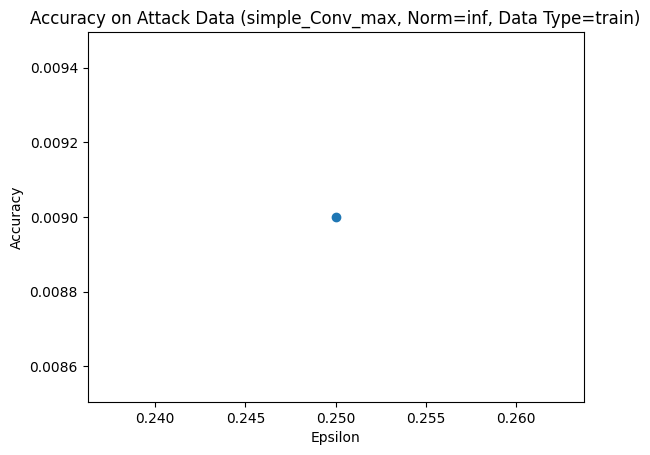

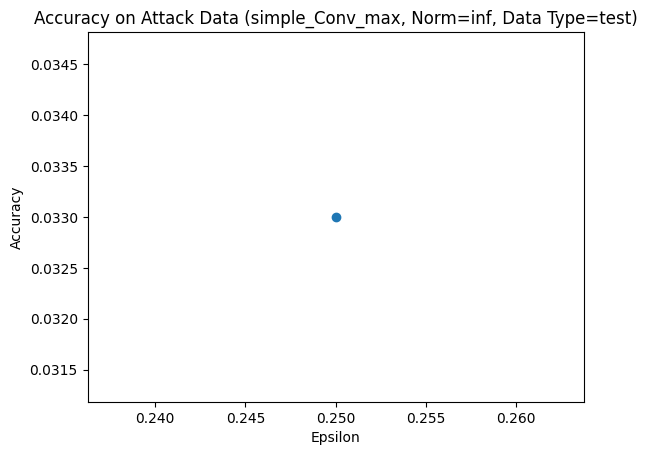

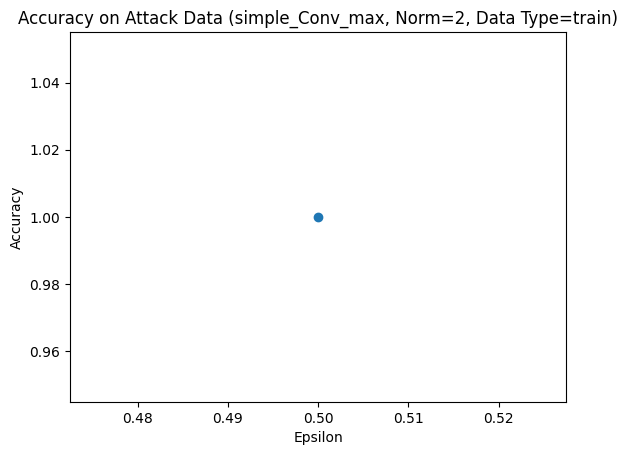

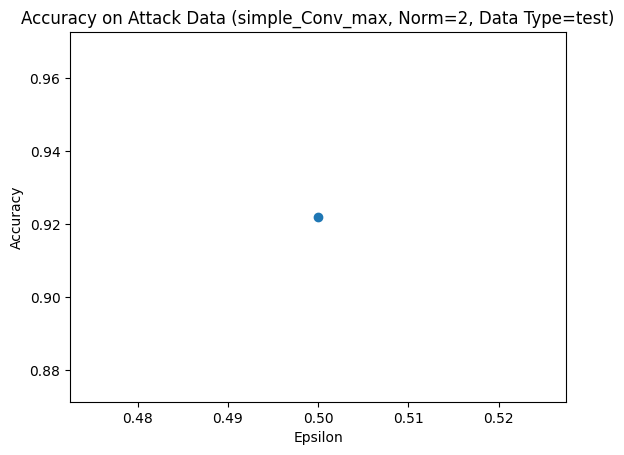

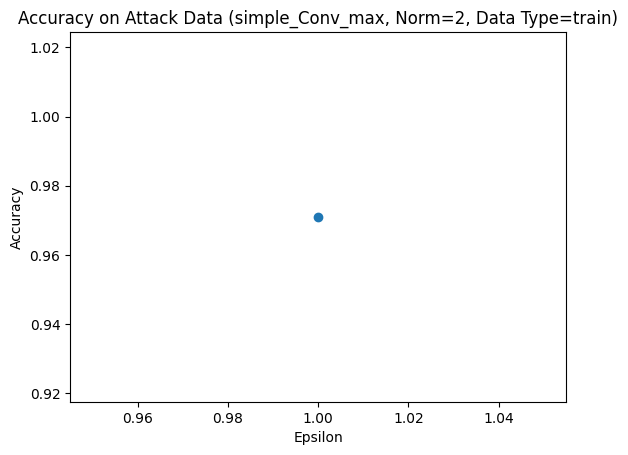

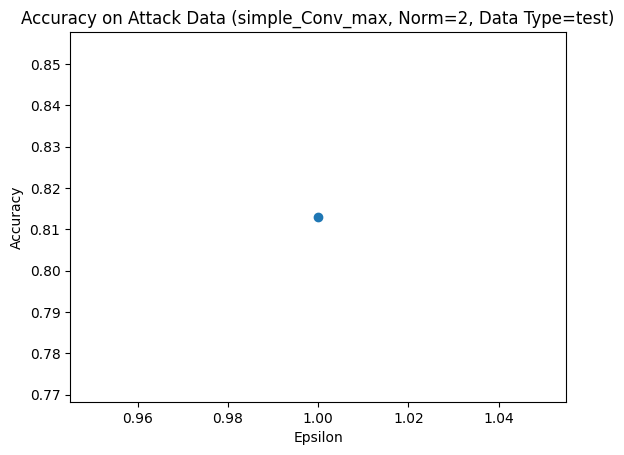

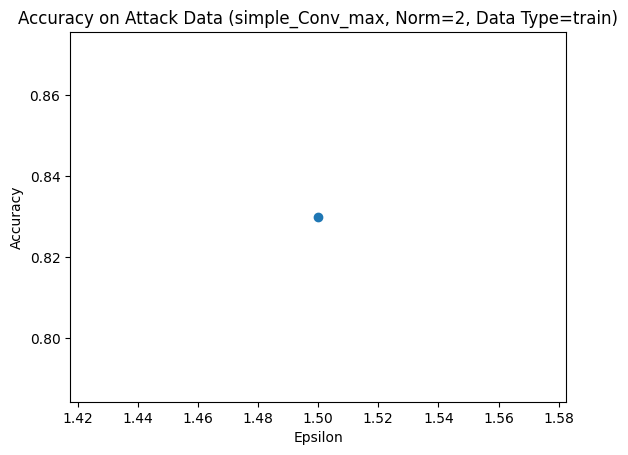

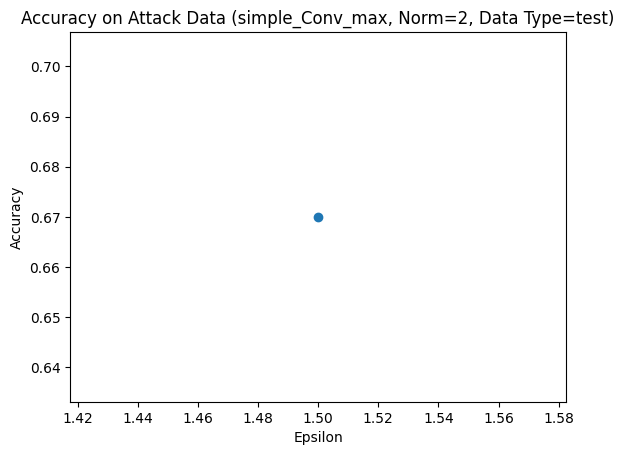

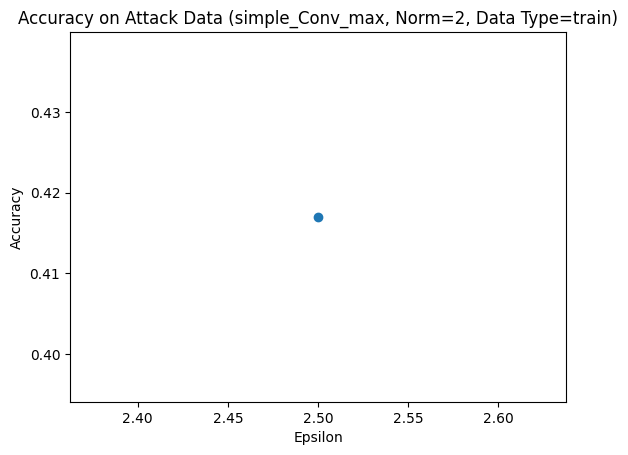

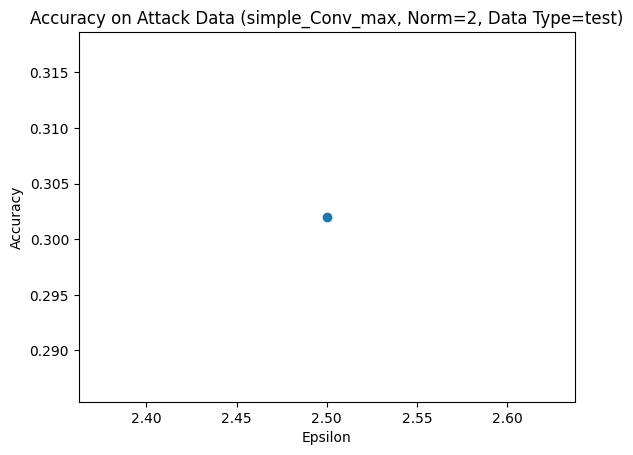

In [36]:

# Step 2: Plot accuracy for attack data
for (model_name, norm, epsilon, data_type), (model,data) in attack_data.items():
    model = model[0]
    # Calculate accuracy on attack data for the model
    predictions = model.predict(data[f'x_{data_type}_attack'])
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(data[f'y_{data_type}_attack'], axis=1)) / len(data[f'y_{data_type}_attack'])

    # Plot the accuracy for the model on the attack data using matplotlib
    plt.figure()
    plt.plot(epsilon, accuracy, marker='o')
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy on Attack Data ({model_name}, Norm={norm}, Data Type={data_type})")
    plt.show()

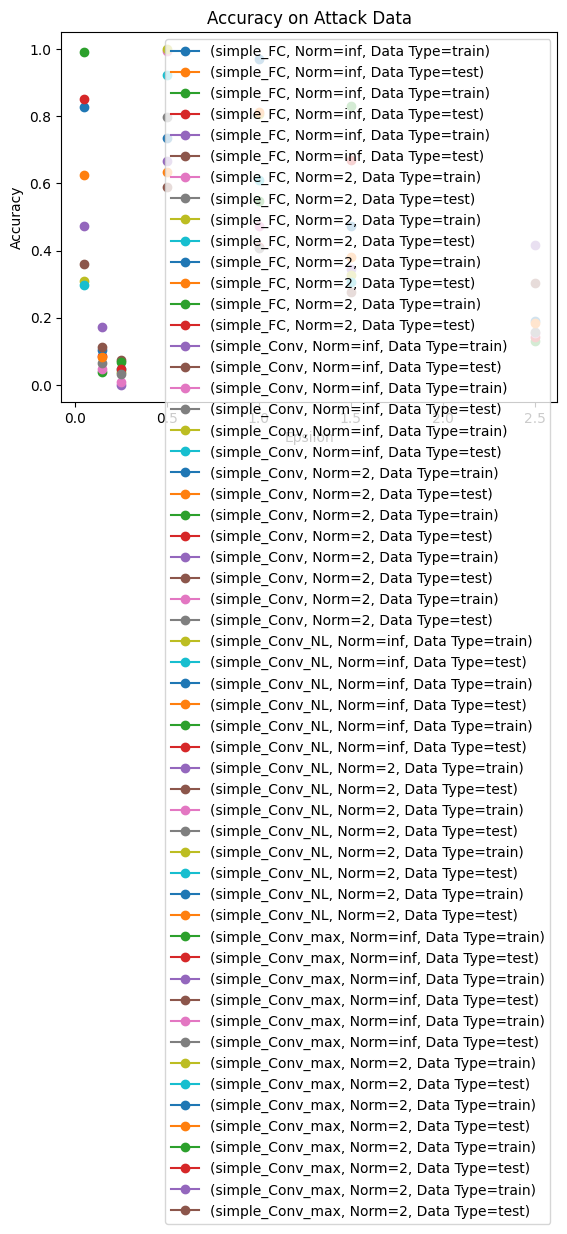

In [37]:
# Step 2: Plot accuracy for attack data
plt.figure()
for (model_name, norm, epsilon, data_type), (model, data) in attack_data.items():
    model = model[0]
    # Calculate accuracy on attack data for the model
    predictions = model.predict(data[f'x_{data_type}_attack'])
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(data[f'y_{data_type}_attack'], axis=1)) / len(data[f'y_{data_type}_attack'])

    # Plot the accuracy for the model on the attack data using matplotlib
    plt.plot(epsilon, accuracy, marker='o', label=f"({model_name}, Norm={norm}, Data Type={data_type})")

plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy on Attack Data')
plt.legend()
plt.show()


In [38]:
import plotly.graph_objects as go

# Step 2: Plot accuracy for attack data
fig = go.Figure()

for (model_name, norm, epsilon, data_type), (model, data) in attack_data.items():
    model = model[0]
    # Calculate accuracy on attack data for the model
    predictions = model.predict(data[f'x_{data_type}_attack'])
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(data[f'y_{data_type}_attack'], axis=1)) / len(data[f'y_{data_type}_attack'])

    # Add trace for the accuracy
    fig.add_trace(go.Scatter(x=[epsilon], y=[accuracy], mode='markers', name=f"({model_name}, Norm={norm}, Data Type={data_type})"))

# Customize the layout
fig.update_layout(
    title='Accuracy on Attack Data',
    xaxis_title='Epsilon',
    yaxis_title='Accuracy'
)

# Show the plot
fig.show()


In [39]:
import plotly.graph_objects as go

# Step 2: Plot accuracy for attack data
fig = go.Figure()

for (model_name, norm, epsilon, data_type), (model, data) in attack_data.items():
    model = model[0]
    # Calculate accuracy on attack data for the model
    predictions = model.predict(data[f'x_{data_type}_attack'])
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(data[f'y_{data_type}_attack'], axis=1)) / len(data[f'y_{data_type}_attack'])

    # Add scatter markers for the accuracy
    fig.add_trace(go.Scatter(
        x=[epsilon],
        y=[accuracy],
        mode='markers',
        name=f"({model_name}, Norm={norm}, Data Type={data_type})",
        marker=dict(size=10)
    ))

# Customize the layout
fig.update_layout(
    title='Accuracy on Attack Data',
    xaxis_title='Epsilon',
    yaxis_title='Accuracy',
    showlegend=True
)

# Show the plot
fig.show()


In [43]:
import plotly.graph_objects as go

# Step 3: Loop over models and plot accuracy for test and train data
fig = go.Figure()

for model_name, model in zip(model_names, models):
    # Calculate accuracy on test data for the model
    predictions = model[0].predict(x_test)
    accuracy_test = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)

    # Calculate accuracy on train data for the model
    predictions = model[0].predict(x_train)
    accuracy_train = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_train, axis=1)) / len(y_train)

    # Add scatter markers for accuracy on test and train data
    fig.add_trace(go.Scatter(
        x=[model_name],
        y=[accuracy_test],
        mode='markers',
        name='Test Data',
        marker=dict(size=10)
    ))

    fig.add_trace(go.Scatter(
        x=[model_name],
        y=[accuracy_train],
        mode='markers',
        name='Train Data',
        marker=dict(size=10)
    ))

# Customize the layout
fig.update_layout(
    title='Accuracy on Test and Train Data',
    xaxis_title='Model',
    yaxis_title='Accuracy',
    showlegend=True
)

# Show the plot
fig.show()


In [ ]:


# Step 2: Plot accuracy for attack data
for (model_name, norm, epsilon, data_type), data in attack_data.items():
    # Calculate accuracy on attack data for the model
    predictions = model.predict(data[f'x_{data_type}_attack'])
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(data[f'y_{data_type}_attack'], axis=1)) / len(data[f'y_{data_type}_attack'])

    # Plot the accuracy for the model on the attack data using matplotlib
    plt.figure()
    plt.plot(epsilon, accuracy, marker='o')
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy on Attack Data ({model_name}, Norm={norm}, Data Type={data_type})")
    plt.show()

# Step 3: Plot accuracy for normal data
predictions = model.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)

# Plot the accuracy for the normal test data using matplotlib
plt.figure()
plt.plot(accuracy, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy on Normal Test Data')
plt.show()

# Step 4: Plot accuracy for other models on attack data
for (model_name, norm, epsilon, data_type), data in attack_data.items():
    for other_model_name in other_models:
        if other_model_name != model_name:
            other_model = load_model(other_model_name)  # Load the other model

            # Calculate accuracy of the other model on the loaded attack data
            other_predictions = other_model.predict(data[f'x_{data_type}_attack'])
            other_accuracy = np.sum(np.argmax(other_predictions, axis=1) == np.argmax(data[f'y_{data_type}_attack'], axis=1)) / len(data[f'y_{data_type}_attack'])

            # Plot the accuracy for the other model on the attack data using matplotlib
            plt.figure()
            plt.plot(epsilon, other_accuracy, marker='o')
            plt.xlabel('Epsilon')
            plt.ylabel('Accuracy')
            plt.title(f"Accuracy of {other_model_name} on Attack Data ({model_name}, Norm={norm}, Data Type={data_type})")
            plt.show()


In [44]:
import plotly.graph_objects as go

# Step 4: Loop over attack data and test other models on it
fig = go.Figure()

for (model_name, norm, epsilon, data_type), (model, data) in attack_data.items():
    # Calculate accuracy on attack data for other models
    for other_model_name, other_model in zip(model_names, models):
        predictions = other_model[0].predict(data[f'x_{data_type}_attack'])
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(data[f'y_{data_type}_attack'], axis=1)) / len(data[f'y_{data_type}_attack'])

        # Add scatter markers for accuracy on attack data
        fig.add_trace(go.Scatter(
            x=[model_name],
            y=[accuracy],
            mode='markers',
            name=f'{other_model_name} ({norm}, {epsilon}) - {data_type}',
            marker=dict(size=10)
        ))

# Customize the layout
fig.update_layout(
    title='Accuracy on Attack Data',
    xaxis_title='Model (Attack Data)',
    yaxis_title='Accuracy',
    showlegend=True
)

# Show the plot
fig.show()


In [45]:
import plotly.express as px

# Step 4: Loop over attack data and test other models on it
df = []

for (model_name, norm, epsilon, data_type), (model, data) in attack_data.items():
    # Calculate accuracy on attack data for other models
    for other_model_name, other_model in zip(model_names, models):
        predictions = other_model[0].predict(data[f'x_{data_type}_attack'])
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(data[f'y_{data_type}_attack'], axis=1)) / len(data[f'y_{data_type}_attack'])

        # Add data to the dataframe
        df.append({
            'Model': other_model_name,
            'Norm': norm,
            'Epsilon': epsilon,
            'Data Type': data_type,
            'Accuracy': accuracy
        })

# Create a grouped bar plot using plotly express
fig = px.bar(df, x='Model', y='Accuracy', color='Norm',
             facet_row='Epsilon', facet_col='Data Type',
             labels={'Model': 'Model', 'Accuracy': 'Accuracy'},
             title='Accuracy on Attack Data',
             template='plotly_white')

# Customize the layout
fig.update_layout(
    legend_title='Norm',
    yaxis_title='Accuracy',
    showlegend=True
)

# Show the plot
fig.show()


In [47]:
import plotly.graph_objects as go

# Step 4: Loop over attack data and test other models on it
model_names = ['Model 1', 'Model 2', 'Model 3']  # Replace with your actual model names

# Create empty lists to store the accuracy values for each combination
norms = []
epsilons = []
train_accuracies = []
test_accuracies = []

for (model_name, norm, epsilon, data_type), (model, data) in attack_data.items():
    # Calculate accuracy on attack data for other models
    for other_model_name, other_model in zip(model_names, models):
        predictions = other_model[0].predict(data[f'x_{data_type}_attack'])
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(data[f'y_{data_type}_attack'], axis=1)) / len(data[f'y_{data_type}_attack'])

        # Add accuracy values to the lists
        norms.append(norm)
        epsilons.append(epsilon)
        if data_type == 'train':
            train_accuracies.append(accuracy)
            test_accuracies.append(None)
        else:
            train_accuracies.append(None)
            test_accuracies.append(accuracy)

# Create the heatmap using plotly
fig = go.Figure(data=go.Heatmap(
    z=test_accuracies,
    x=model_names,
    y=epsilons,
    customdata=train_accuracies,
    hovertemplate='Model: %{x}<br>Norm: %{y}<br>Train Accuracy: %{customdata}<br>Test Accuracy: %{z}<extra></extra>',
    colorscale='Viridis'
))

# Customize the layout
fig.update_layout(
    title='Accuracy on Attack Data',
    xaxis_title='Models',
    yaxis_title='Epsilons',
    yaxis=dict(
        tickmode='array',
        tickvals=epsilons,
        ticktext=[f'Epsilon {epsilon}' for epsilon in epsilons]
    ),
    showlegend=False
)

# Show the plot
fig.show()


In [49]:
import plotly.express as px
import pandas as pd
import itertools

# Step 4: Loop over attack data and test other models on it

# Create empty lists to store the accuracy values for each combination
norms = []
epsilons = []
accuracies = []
data_types = []

for (model_name, norm, epsilon, data_type), (model, data) in attack_data.items():
    # Calculate accuracy on attack data for other models
    for other_model_name, other_model in zip(model_names, models):
        predictions = other_model[0].predict(data[f'x_{data_type}_attack'])
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(data[f'y_{data_type}_attack'], axis=1)) / len(data[f'y_{data_type}_attack'])

        # Add accuracy values to the lists
        norms.append(norm)
        epsilons.append(epsilon)
        accuracies.append(accuracy)
        data_types.append(data_type)

# Create a Cartesian product of model names and epsilons
combinations = list(itertools.product(model_names, epsilons))

# Create the bar chart using plotly express
fig = px.bar(
    data_frame=pd.DataFrame({'Model': combinations, 'Accuracy': accuracies}),
    x='Model',
    y='Accuracy',
    color='Accuracy',
    labels={'Model': 'Model', 'Accuracy': 'Accuracy'},
    title='Accuracy on Attack Data',
    hover_data={'Model': False, 'Accuracy': ':.2%'},
    width=800,
    height=500
)

# Customize the layout
fig.update_layout(
    xaxis={'categoryorder': 'array', 'categoryarray': model_names},
    coloraxis=dict(
        colorbar=dict(
            title='Accuracy',
            tickformat='.2%',
            ticksuffix='%',
            lenmode='fraction',
            len=0.5
        )
    ),
    font=dict(size=12),
    showlegend=False
)

# Show the plot
fig.show()


NameError: ignored

In [56]:
import plotly.express as px
import itertools

# Step 4: Loop over attack data and test other models on it

# Create empty lists to store the accuracy values for each combination
norms = []
epsilons = []
accuracies = []
data_types = []

for (model_name, norm, epsilon, data_type), (model, data) in attack_data.items():
    # Calculate accuracy on attack data for other models
    for other_model_name, other_model in zip(model_names, models):
        predictions = other_model[0].predict(data[f'x_{data_type}_attack'])
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(data[f'y_{data_type}_attack'], axis=1)) / len(data[f'y_{data_type}_attack'])

        # Add accuracy values to the lists
        norms.append(norm)
        epsilons.append(epsilon)
        accuracies.append(accuracy)
        data_types.append(data_type)

# Create a Cartesian product of model names and epsilons
combinations = list(itertools.product(model_names, epsilons))
# Repeat the accuracies to match the length of combinations
accuracies_repeated = np.repeat(accuracies, len(model_names))

# Create the bar chart using plotly express
fig = px.bar(
    data_frame=pd.DataFrame({'Model': combinations, 'Accuracy': accuracies_repeated}),
    x='Model',
    y='Accuracy',
    color='Accuracy',
    labels={'Model': 'Model', 'Accuracy': 'Accuracy'},
    title='Accuracy on Attack Data',
    hover_data={'Model': False, 'Accuracy': ':.2%'},
    width=800,
    height=500
)

# Customize the layout
fig.update_layout(
    xaxis={'categoryorder': 'array', 'categoryarray': model_names},
    coloraxis=dict(
        colorbar=dict(
            title='Accuracy',
            tickformat='.2%',
            ticksuffix='%',
            lenmode='fraction',
            len=0.5
        )
    ),
    font=dict(size=12),
    showlegend=False
)

# Show the plot
fig.show()


In [53]:
len(combinations)

504

In [54]:
len(accuracies)

168

In [18]:
from tensorflow import keras



In [ ]:
from tensorflow import keras

def simple_Conv_max(n_hidden, kernel_size=28):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(n_hidden, kernel_size=kernel_size, padding='same', input_shape=(28, 28, 1), activation='relu'))
    model.add(keras.layers.AdaptiveMaxPooling2D(pool_size=(1, 1)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(10))

    return model


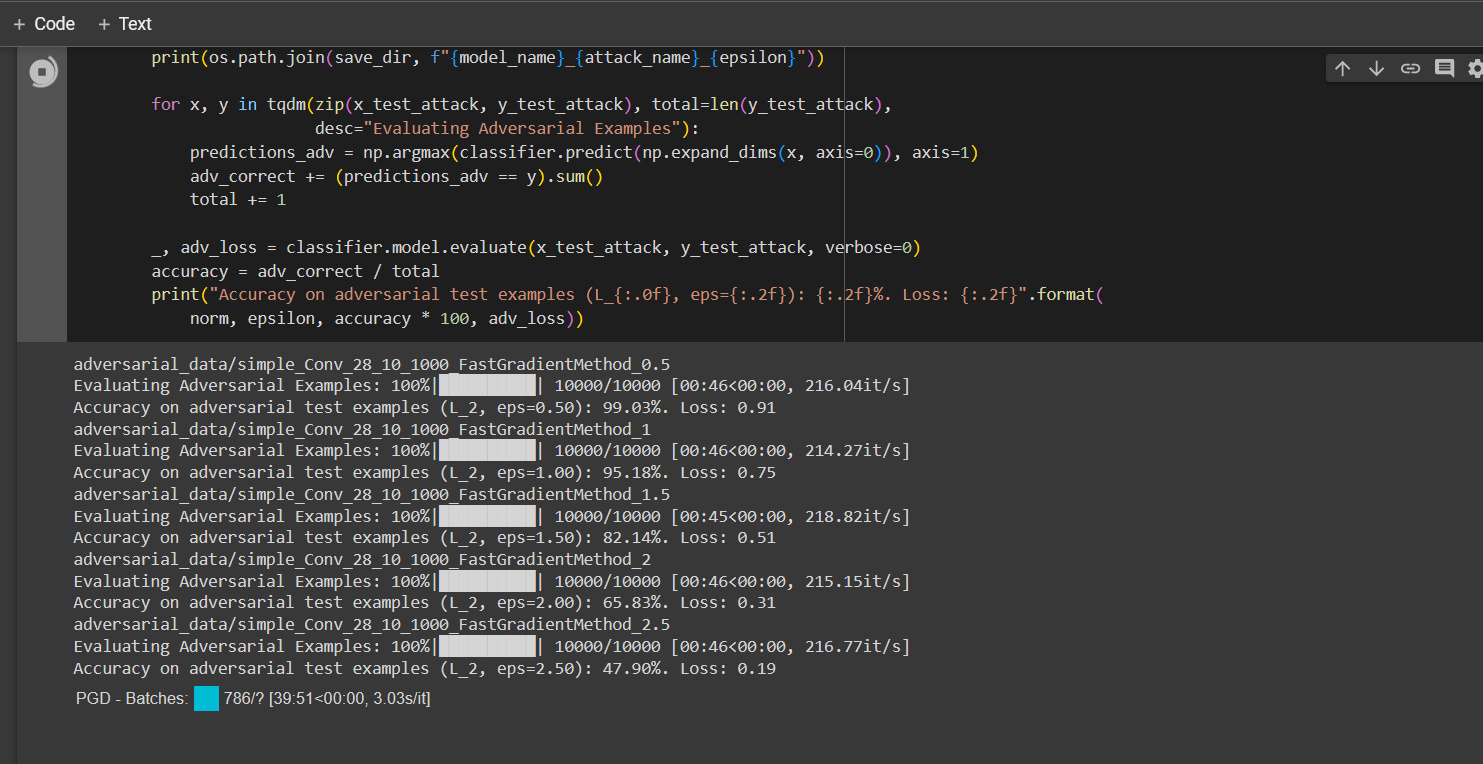

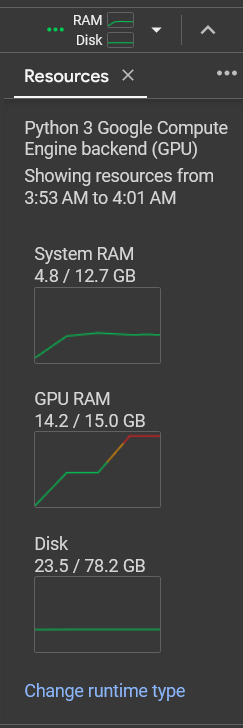

In [211]:
def shift_images(images, shift, axis = 0):
    #axis = np.random.randint(0, 2)
    shifted_images = np.roll(images, shift, axis=axis)
    return shifted_images


In [196]:
def evaluate_shift_invariance(model, x_test, y_test, shifts):
    model = model[0]
    accuracies = []
    for shift in tqdm(shifts):
        shifted_images = shift_images(x_test, shift)
        predictions = model.predict(shifted_images)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        accuracies.append(accuracy)
    return accuracies
shifts = range(10,-11,-1)
results = []
for model in tqdm(models):
    
    accuracy = evaluate_shift_invariance(model, x_test, y_test, shifts)
    results.append(accuracy)



100%|██████████| 4/4 [08:55<00:00, 133.80s/it]


In [197]:
import matplotlib.pyplot as plt
results = []
model_names = ['simple_FC', 'simple_Conv', 'simple_Conv_NL', 'simple_Conv_max']

for model, model_name in zip(models, model_names):
    accuracy = evaluate_shift_invariance(model, x_test, y_test, shifts)
    results.append((model_name, accuracy))


100%|██████████| 11/11 [03:08<00:00, 17.11s/it]


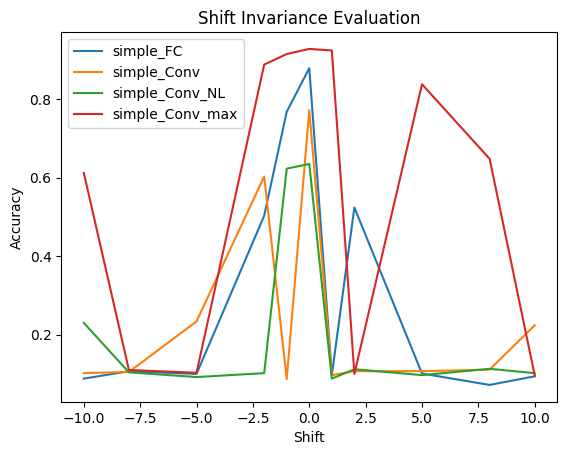

In [198]:
for model_name, accuracy in results:
    plt.plot(shifts, accuracy, label=model_name)

plt.xlabel('Shift')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Shift Invariance Evaluation')
plt.show()


In [212]:
results_abs = []
for model_k in range(len(results)):
    shifts_abs = []
    results_abs_k = []
    for k in range(len(shifts)//2+1):
        shifts_abs.append(shifts[-k-1])
        results_abs_k.append((results[model_k][1][k]+results[model_k][1][-k-1])/2)
    results_abs.append((results[model_k][0],results_abs_k))


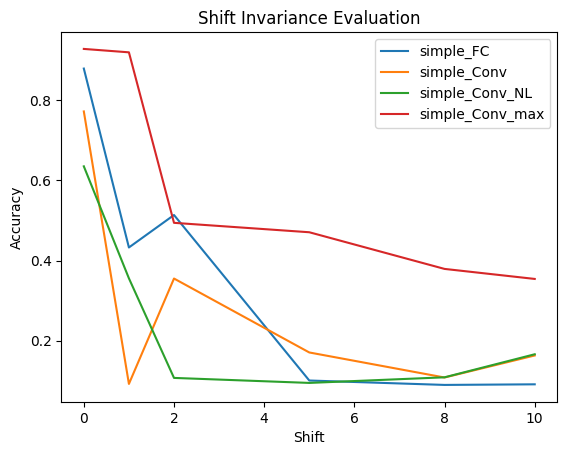

In [209]:
for model_name, accuracy in results_abs:
    plt.plot(shifts_abs, accuracy, label=model_name)

plt.xlabel('Shift')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Shift Invariance Evaluation')
plt.show()


100%|██████████| 21/21 [05:50<00:00, 16.67s/it]


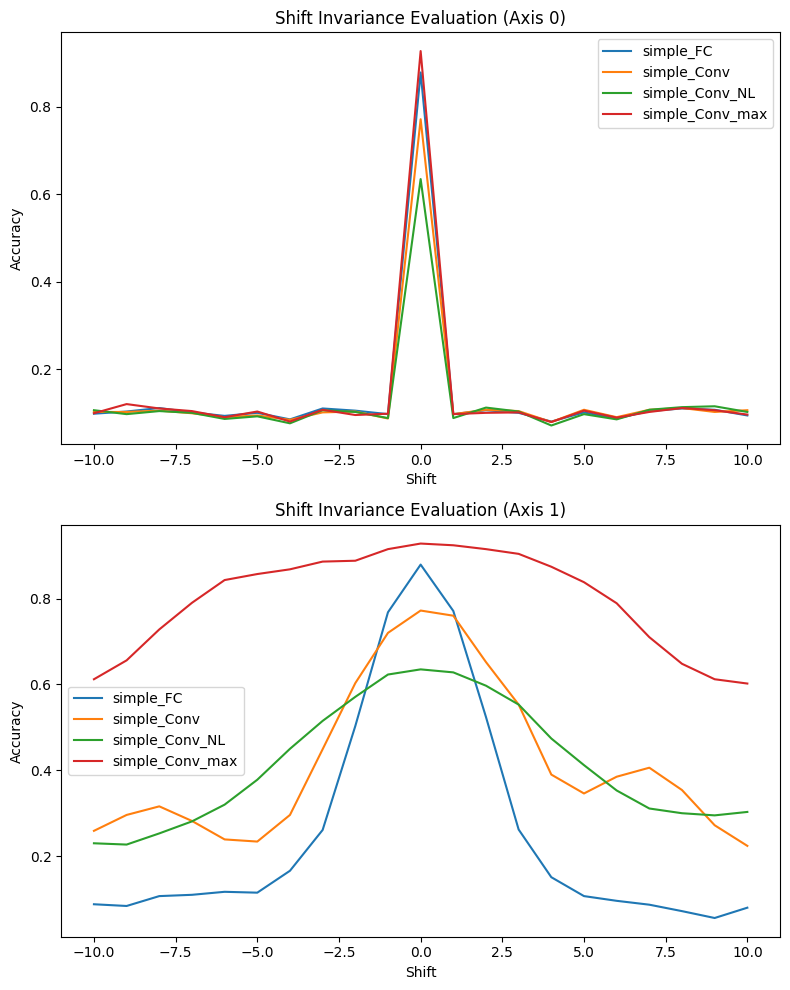

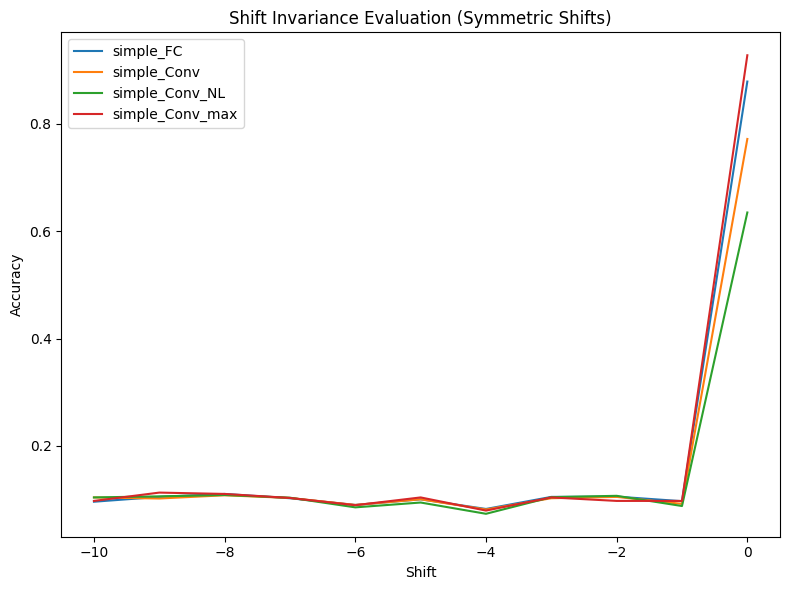

In [215]:
import matplotlib.pyplot as plt

def shift_images(images, shift, axis=0):
    shifted_images = np.roll(images, shift, axis=axis)
    return shifted_images

def evaluate_shift_invariance(model, x_test, y_test, shifts, axis=0):
    accuracies = []
    for shift in tqdm(shifts):
        shifted_images = shift_images(x_test, shift, axis=axis)
        predictions = model.predict(shifted_images)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        accuracies.append(accuracy)
    return accuracies

shifts = range(10, -11, -1)
results = []
model_names = ['simple_FC', 'simple_Conv', 'simple_Conv_NL', 'simple_Conv_max']

for model, model_name in zip(models, model_names):
    model = model[0]
    accuracy_axis0 = evaluate_shift_invariance(model, x_test, y_test, shifts, axis=0)
    accuracy_axis1 = evaluate_shift_invariance(model, x_test, y_test, shifts, axis=1)
    results.append((model_name, accuracy_axis0, accuracy_axis1))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

for model_name, accuracy_axis0, accuracy_axis1 in results:
    axes[0].plot(shifts, accuracy_axis0, label=model_name)
    axes[1].plot(shifts, accuracy_axis1, label=model_name)

axes[0].set_xlabel('Shift')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].set_title('Shift Invariance Evaluation (Axis 0)')

axes[1].set_xlabel('Shift')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Shift Invariance Evaluation (Axis 1)')

plt.tight_layout()
plt.show()

results_abs = []
for model_k in range(len(results)):
    shifts_abs = []
    results_abs_k = []
    for k in range(len(shifts)//2+1):
        shifts_abs.append(shifts[-k-1])
        results_abs_k.append((results[model_k][1][k] + results[model_k][1][-k-1]) / 2)
    results_abs.append((results[model_k][0], results_abs_k))
    
fig, ax = plt.subplots(figsize=(8, 6))

for model_name, accuracy in results_abs:
    ax.plot(shifts_abs, accuracy, label=model_name)

ax.set_xlabel('Shift')
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_title('Shift Invariance Evaluation (Symmetric Shifts)')

plt.tight_layout()
plt.show()


In [1]:

results_abs = []
for model_k in range(len(results)):
    shifts_abs = []
    results_abs_k = []
    for k in range(len(shifts)//2+1):
        shifts_abs.append(shifts[-k-1])
        results_abs_k.append((results[model_k][2][k] + results[model_k][2][-k-1]) / 2)
    results_abs.append((results[model_k][0], results_abs_k))
    
fig, ax = plt.subplots(figsize=(8, 6))

for model_name, accuracy in results_abs:
    ax.plot(shifts_abs, accuracy, label=model_name)

ax.set_xlabel('Shift')
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_title('Shift Invariance Evaluation (Symmetric Shifts)')

plt.tight_layout()
plt.show()


NameError: ignored

In [ ]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_visible_devices(physical_devices[:num_gpus], "GPU")
logical_devices = tf.config.experimental.list_logical_devices("GPU")
tf.distribute.OneDeviceStrategy(logical_devices[0])
tf.distribute.MirroredStrategy(logical_devices)

In [2]:

# Load MNIST dataset
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()

def circular_padding(x, padding_size):
    # Perform circular padding on the input tensor
    return tf.pad(x, [[0, 0], [padding_size, padding_size], [padding_size, padding_size], [0, 0]], mode='SYMMETRIC')

def simple_Conv(n_hidden, kernel_size=28, padding_size=-1):
    if padding_size == -1:
        padding_size = kernel_size // 2

    model = Sequential()
    model.add(Lambda(lambda x: circular_padding(x, padding_size), input_shape=(28, 28, 1)))
    model.add(Conv2D(n_hidden, kernel_size=kernel_size, padding='valid'))
    model.add(ReLU())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(10))

    return model

n_hidden = 1000
padding_sizes = [0, 2, 4, 6, 8, 10, 12, 14]
padding_size = padding_sizes[5]

@tf.function
def train_step(model, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# Create the CNN model and optimizer
model = simple_Conv(n_hidden, kernel_size=28, padding_size=padding_size)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, decay=5e-4)
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Create the ART classifier
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    classifier = TensorFlowV2Classifier(
        model=model,
        loss_object=loss_object,
        train_step=train_step,
        nb_classes=10,
        input_shape=(28, 28, 1),
        clip_values=(0, 1),
    )

# Fit the classifier to the training data
classifier_history = classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3, verbose=2)

# Perform predictions and evaluate accuracy on benign test examples
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

import numpy as np
from tqdm import tqdm
import os
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescentTensorFlowV2

# Define attack parameters
attack_params = [[2, [0.5, 1, 1.5, 2, 2.5]], [np.inf, [0.05, 0.1, 0.15, 0.2, 0.25]]]

# Iterate over the attack parameters and generate adversarial examples
for norm, epsilons in attack_params:
    for epsilon in epsilons:
        if norm == 2:
            attack = FastGradientMethod(estimator=classifier, eps=epsilon, norm=norm)
        else:
            attack = ProjectedGradientDescentTensorFlowV2(estimator=classifier, eps=epsilon, norm=norm)

        attack_name = attack.__class__.__name__
        model_name = "simple_Conv_28_10_1000"

        adv_correct = 0
        adv_loss = 0
        total = 0
        x_train_attack = []
        y_train_attack = []
        x_test_attack = []
        y_test_attack = []

        x_train_attack = attack.generate(x=x_train)
        y_train_attack = np.copy(y_train)

        x_test_attack = attack.generate(x=x_test)
        y_test_attack = np.copy(y_test)

        x_train_attack = np.array(x_train_attack)
        y_train_attack = np.array(y_train_attack)
        x_test_attack = np.array(x_test_attack)
        y_test_attack = np.array(y_test_attack)

        save_dir = "adversarial_data"
        os.makedirs(save_dir, exist_ok=True)
        np.savez(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}_train.npz"),
                 x_train_attack=x_train_attack, y_train_attack=y_train_attack)
        np.savez(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}_test.npz"),
                 x_test_attack=x_test_attack, y_test_attack=y_test_attack)

        print(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}"))

        for x, y in tqdm(zip(x_test_attack, y_test_attack), total=len(y_test_attack),
                         desc="Evaluating Adversarial Examples"):
            predictions_adv = np.argmax(classifier.predict(np.expand_dims(x, axis=0)), axis=1)
            adv_correct += (predictions_adv == y).sum()
            total += 1

        _, adv_loss = classifier.model.evaluate(x_test_attack, y_test_attack, verbose=0)
        accuracy = adv_correct / total
        print("Accuracy on adversarial test examples (L_{:.0f}, eps={:.2f}): {:.2f}%. Loss: {:.2f}".format(
            norm, epsilon, accuracy * 100, adv_loss))


ModuleNotFoundError: ignored